In [ ]:
import ast
import itertools
import multiprocessing
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from src.api.models.vector_index import FAISSIndexWithMetadata
from src.config import UNKNOWN_CLASS_ID
from torchvision.ops import nms
from tqdm import tqdm

from experiment.prediction_utils import (
    calculate_metrics,
    create_confusion_matrix,
    create_per_class_metrics_df,
    evaluate_predictions,
    render_confusion_matrix,
    update_confusion_matrix,
)
from experiment.settings import (
    CLASS_ID_TO_NAME,
    FINAL_PREDICTIONS_PATH,
    FULLY_LABELED_RECORDINGS,
    OBJECT_DATASETS_PATH,
    TRIAL_RECORDING_IDS,
    VECTOR_INDEXES_PATH,
)

In [2]:
GROUND_TRUTH_PATH = Path("data/ground_truth.csv")
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
ground_truth_df.head()

,recording_id,frame_idx,class_id,mask_area,laplacian_variance,x1,y1,x2,y2
0,67b71a70-da64-467a-9fb6-91bc29265fd1,223,1,5384,56.868510,1045,467,1107,567
1,67b71a70-da64-467a-9fb6-91bc29265fd1,42,1,1433,144.979676,645,451,679,498
2,67b71a70-da64-467a-9fb6-91bc29265fd1,86,1,1410,166.952593,665,437,698,485
3,67b71a70-da64-467a-9fb6-91bc29265fd1,242,1,8206,54.435912,902,449,978,572
4,67b71a70-da64-467a-9fb6-91bc29265fd1,21,1,1445,165.012037,642,450,676,498


In [ ]:
def top_k_avg_prediction(
    index,
    object_df: pd.DataFrame,
    max_distance: float,
    k: int,
    min_mask_area_size: int,
    unknown_iou_threshold: float = 0.5,
    eps: float = 1e-6,
) -> pd.DataFrame:
    """
    Performs a batched top-k vector search for every object's embedding, then determines the final
    prediction with confidence.

    Known classes: one prediction per frame-class (argmax).
    Unknown class: allow multiple predictions per frame but apply NMS to suppress overlaps.

    Assumes object_df includes columns: 'frame_idx', 'object_id', 'embedding', 'x1','y1','x2','y2'.

    Adds two new columns:
      - 'predicted_class_id': the majority-vote class per object_id
      - 'predicted_confidence': the aggregated confidence score per object_id

    Parameters:
      index: FAISSIndexWithMetadata-like object for search
      object_df: DataFrame with detection info and embeddings
      max_distance: maximum distance to accept a candidate
      k: number of top search results per embedding
      min_mask_area_size: minimum mask area for accepting metadata
      unknown_iou_threshold: IoU threshold for NMS on unknown-class candidates
      eps: small epsilon to add before inversion (stabilize confidence)

    Returns:
      DataFrame with 'predicted_class_id', 'predicted_confidence', dropping 'embedding' and box cols.
    """
    # 1. Prepare embeddings
    embeddings_list = object_df["embedding"].apply(ast.literal_eval).tolist()
    embedding_tensor = torch.from_numpy(np.array(embeddings_list))  # (N, d)

    # 2. FAISS/Batched search
    distances_batch, indices_batch = index.search(embedding_tensor, k)

    # 3. Collect valid candidates with confidence + boxes
    rows = []
    for i, (frame_idx, object_id, x1, y1, x2, y2) in enumerate(
        zip(
            object_df["frame_idx"],
            object_df["object_id"],
            object_df["x1"],
            object_df["y1"],
            object_df["x2"],
            object_df["y2"],
            strict=False,
        )
    ):
        distances = distances_batch[i]
        idxs = indices_batch[i]
        metas = index.get_metadatas(idxs)
        for dist, meta in zip(distances, metas, strict=False):
            if dist <= max_distance and meta.get("mask_area", 0) >= min_mask_area_size:
                conf = 1.0 / (dist + eps)
                rows.append({
                    "frame_idx": frame_idx,
                    "object_id": object_id,
                    "distance": float(dist),
                    "confidence": conf,
                    "class_id": meta.get("class_id", UNKNOWN_CLASS_ID),
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2,
                })

    results_df = pd.DataFrame(rows)
    if results_df.empty:
        # no valid candidates at all
        out = object_df.copy()
        out["predicted_class_id"] = UNKNOWN_CLASS_ID
        out["predicted_confidence"] = 0.0
        return out.drop(columns=["embedding", "x1", "y1", "x2", "y2"], errors="ignore")

    # 4. Handle known vs unknown
    # Known: at most one per frame-class
    known = results_df[results_df["class_id"] != UNKNOWN_CLASS_ID]
    known_top = known.sort_values(
        ["frame_idx", "class_id", "confidence"], ascending=[True, True, False]
    ).drop_duplicates(subset=["frame_idx", "class_id"], keep="first")

    # Unknown: allow multiple, but apply NMS per frame
    unknown = results_df[results_df["class_id"] == UNKNOWN_CLASS_ID]
    keep_idx = []
    for fidx, grp in unknown.groupby("frame_idx"):
        boxes = torch.tensor(grp[["x1", "y1", "x2", "y2"]].values, dtype=torch.float)
        scores = torch.tensor(grp["confidence"].values, dtype=torch.float)
        keep = nms(boxes, scores, unknown_iou_threshold)
        keep_idx.extend(grp.iloc[keep.tolist()].index.tolist())
    unknown_keep = unknown.loc[keep_idx]

    top_per_frame = pd.concat([known_top, unknown_keep], ignore_index=True)

    # 5. Frame-level aggregation: mean distance & confidence per (frame_idx,object_id,class_id)
    agg = top_per_frame.groupby(
        ["frame_idx", "object_id", "class_id"], as_index=False
    ).agg({"distance": "mean", "confidence": "mean"})
    best = agg.loc[
        agg.groupby(["frame_idx", "object_id"])["distance"].idxmin()
    ].reset_index(drop=True)

    # 6. Object-level: majority-vote + avg confidence
    final_cls = (
        best.groupby("object_id")["class_id"]
        .apply(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    final_conf = {}
    for obj, grp in best.groupby("object_id"):
        cls = final_cls.get(obj, UNKNOWN_CLASS_ID)
        confs = grp.loc[grp["class_id"] == cls, "confidence"]
        final_conf[obj] = float(confs.mean()) if not confs.empty else 0.0

    # 7. Map back and cleanup
    out_df = object_df.copy()
    out_df["predicted_class_id"] = (
        out_df["object_id"].map(final_cls).fillna(UNKNOWN_CLASS_ID).astype(int)
    )
    out_df["predicted_confidence"] = out_df["object_id"].map(final_conf).fillna(0.0)
    return out_df.drop(columns=["embedding"], errors="ignore")

In [ ]:
vector_indexes = {
    "same_background": {
        int(path.stem.split("_")[0]): FAISSIndexWithMetadata.load(path)
        for path in (VECTOR_INDEXES_PATH / "same_background").glob("*.index")
    },
    "diff_background": {
        int(path.stem.split("_")[0]): FAISSIndexWithMetadata.load(path)
        for path in (VECTOR_INDEXES_PATH / "diff_background").glob("*.index")
    },
}

labeling_sets = ["same_background"]
sample_counts = vector_indexes[labeling_sets[0]].keys()
sample_counts = [600]
k_values = [10, 20, 50, 100]
max_distance_values = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
min_mask_area_sizes = [0]  # , 200, 400, 600, 800, 1000, 2000, 3000, 4000]

total_possibilities = (
    len(labeling_sets)
    * len(sample_counts)
    * len(k_values)
    * len(max_distance_values)
    * len(min_mask_area_sizes)
)
num_possibilities_tried = 0

In [6]:
def process_grid_combination(params):
    """
    Process a single grid combination.

    Parameters:
        params (tuple): A tuple (sample_count, k, confidence, min_mask_area_size)

    Returns:
        tuple: A tuple containing the grid_key, the confusion matrix, and the calculated metrics.
    """
    labeling_set, sample_count, k, max_distance, min_mask_area_size = params
    cm = create_confusion_matrix()
    index = vector_indexes[labeling_set][sample_count]
    dataset_paths = list(OBJECT_DATASETS_PATH.iterdir())
    for object_dataset_path in dataset_paths:
        trial_recording_id = object_dataset_path.stem
        object_df = pd.read_csv(object_dataset_path)

        predictions_df = top_k_avg_prediction(
            index,
            object_df,
            max_distance=max_distance,
            k=k,
            min_mask_area_size=min_mask_area_size,
        )

        gt_df = ground_truth_df[
            ground_truth_df["recording_id"] == trial_recording_id
        ].copy()

        evaluation_df = evaluate_predictions(predictions_df, gt_df, iou_threshold=0.5)

        update_confusion_matrix(cm, evaluation_df)

    metrics = calculate_metrics(cm)
    return params, cm, metrics

In [7]:
params_list = list(
    itertools.product(
        labeling_sets, sample_counts, k_values, max_distance_values, min_mask_area_sizes
    )
)
total_possibilities = len(params_list)

print(f"Processing {total_possibilities} possibilities using multiprocessing...")

grid_search_confusion_matrices = {}
grid_search_metrics = {}

with multiprocessing.Pool() as pool:
    # imap_unordered yields results as soon as they’re ready
    for grid_key, cm, metrics in tqdm(
        pool.imap_unordered(process_grid_combination, params_list),
        total=total_possibilities,
        desc="Grid search",
    ):
        grid_search_confusion_matrices[grid_key] = cm
        grid_search_metrics[grid_key] = metrics

print("All done!")

Processing 36 possibilities using multiprocessing...


Grid search: 100%|██████████| 36/36 [01:17<00:00,  2.14s/it]

All done!


# Analyze grid search results 

In [8]:
per_class_metrics_df = create_per_class_metrics_df(grid_search_metrics)
per_class_metrics_df.head()

,labeling_set,sample_count,k,confidence,min_mask_area_size,class_id,precision,recall,f1,support,unknown_rate
0,same_background,600,10,0.65,0,-3,0.000000,0.000000,0.000000,5949,0.540091
1,same_background,600,10,0.65,0,-2,0.000000,0.000000,0.000000,0,0.000000
2,same_background,600,10,0.65,0,-1,0.000000,0.000000,0.000000,0,0.000000
3,same_background,600,10,0.65,0,1,0.554455,0.864198,0.675513,324,0.000000
4,same_background,600,10,0.65,0,2,0.551724,0.481928,0.514469,166,0.000000


In [9]:
color_mapping = {
    "precision": "tab:blue",
    "recall": "tab:orange",
    "f1": "tab:green",
    "unknown_rate": "tab:red",
}

In [10]:
counts = ground_truth_df["class_id"].value_counts().sort_index()
print("Ground truth samples per class:")
for cls, cnt in counts.items():
    print(f"Class {CLASS_ID_TO_NAME[cls]}: {cnt}")

Ground truth samples per class:
Class naaldcontainer: 324
Class spuit: 166
Class keukenmes: 176
Class infuus: 168
Class stethoscoop: 248
Class bol wol: 110
Class snoep: 117
Class nuchter: 108
Class fotokader: 116
Class iced tea: 90
Class bril: 130
Class scherm: 117
Class rollator: 125
Class ampulevloeistof: 136
Class ampulepoeder: 59


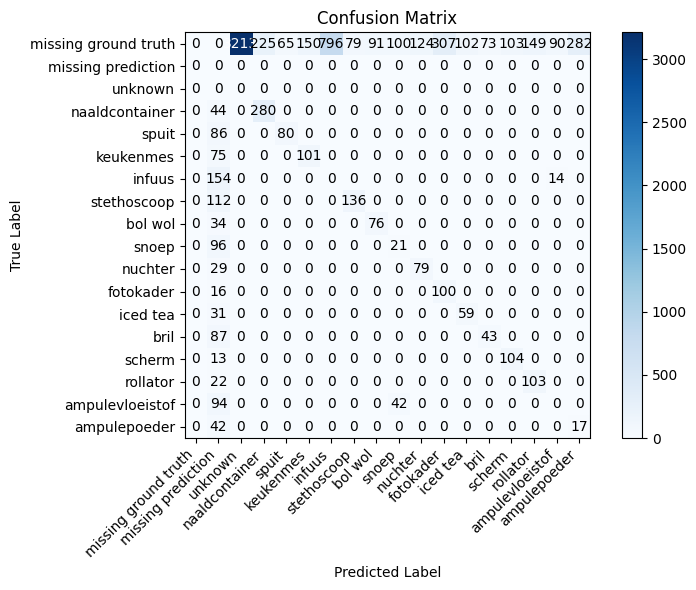

Best grid key: ('same_background', 600, 10, 0.65, 0)


In [ ]:
# Select the grid key with the highest overall F1 score.
best_key = max(
    grid_search_metrics, key=lambda key: grid_search_metrics[key]["micro"]["f1"]
)
best_metrics = grid_search_metrics[best_key]
best_confusion_matrix = grid_search_confusion_matrices[best_key]

render_confusion_matrix(best_confusion_matrix)

print(f"Best grid key: {best_key}")

In [ ]:
if FINAL_PREDICTIONS_PATH.exists():
    shutil.rmtree(FINAL_PREDICTIONS_PATH)
FINAL_PREDICTIONS_PATH.mkdir(parents=True, exist_ok=True)

for trial_recording_id in TRIAL_RECORDING_IDS:
    if trial_recording_id not in FULLY_LABELED_RECORDINGS:
        continue

    object_dataset_path = OBJECT_DATASETS_PATH / f"{trial_recording_id}.csv"
    object_df = pd.read_csv(object_dataset_path)

    labeling_set, sample_count, k, max_distance, min_mask_area_size = best_key

    predictions_df = top_k_avg_prediction(
        vector_indexes[labeling_set][sample_count],
        object_df,
        max_distance=max_distance,
        k=k,
        min_mask_area_size=min_mask_area_size,
    )

    predictions_df.to_csv(
        FINAL_PREDICTIONS_PATH / f"{trial_recording_id}.csv", index=False
    )

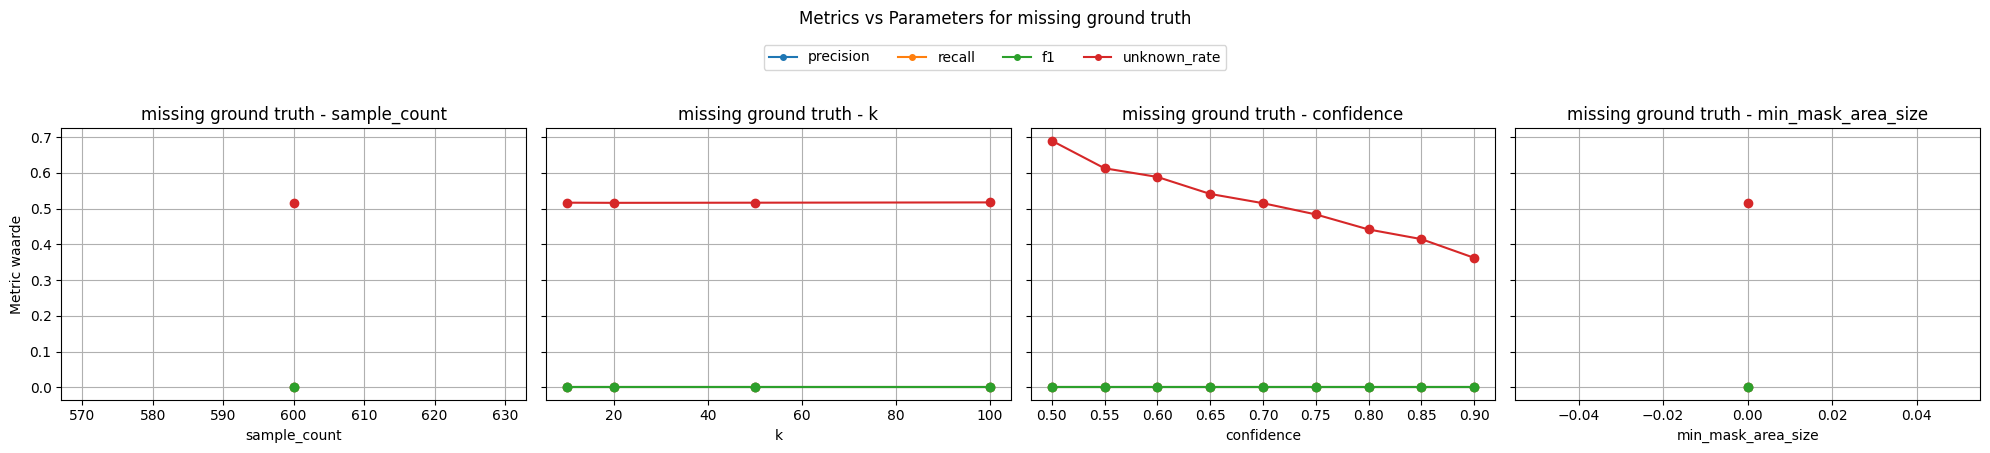

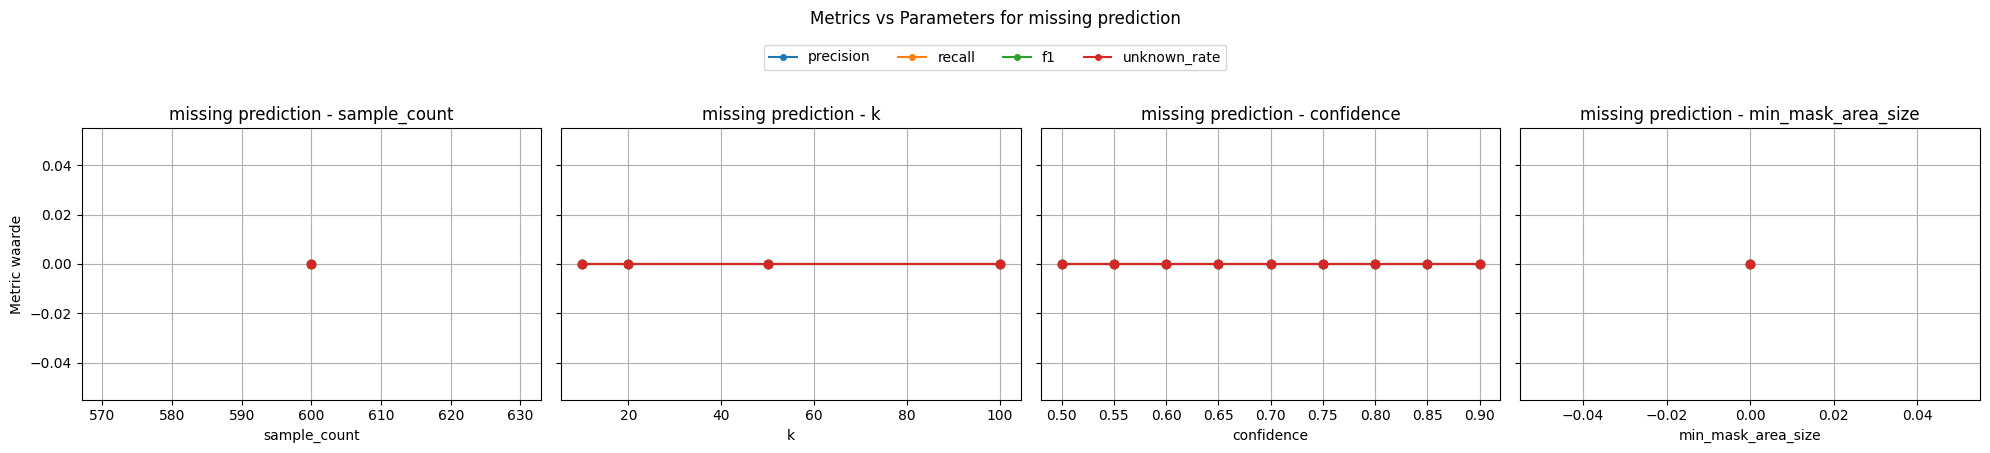

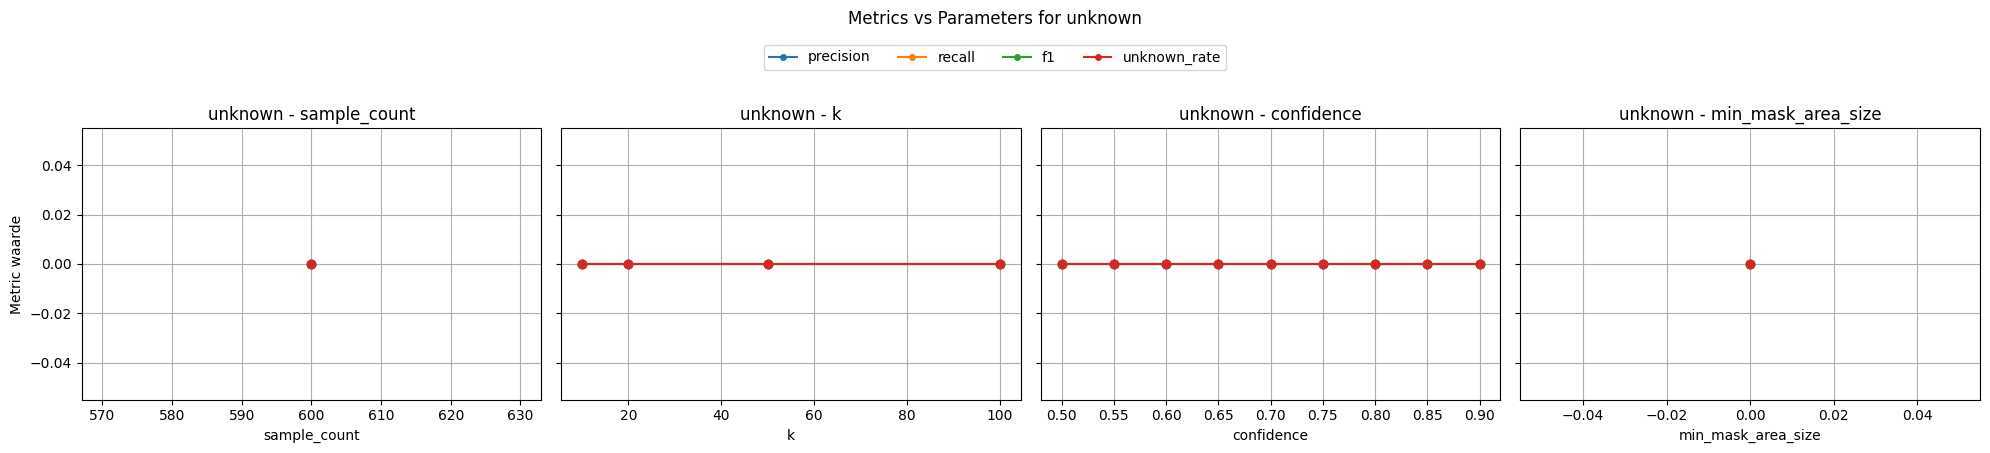

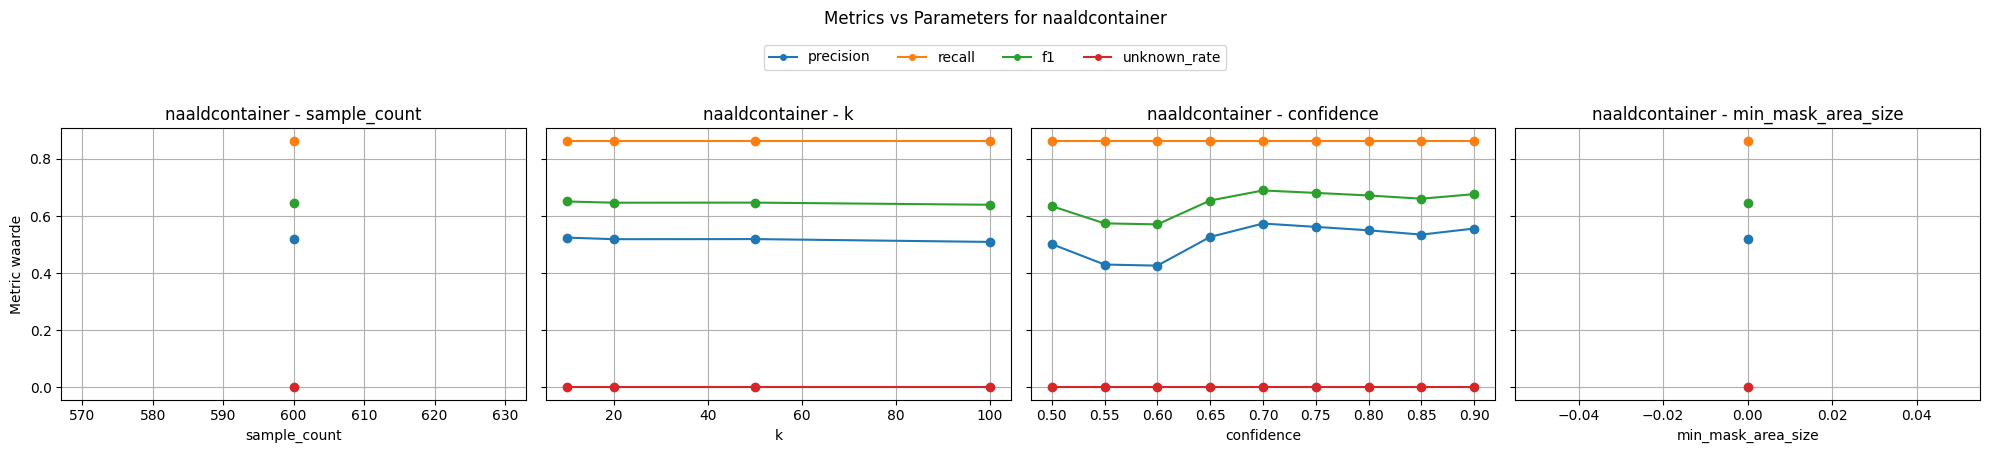

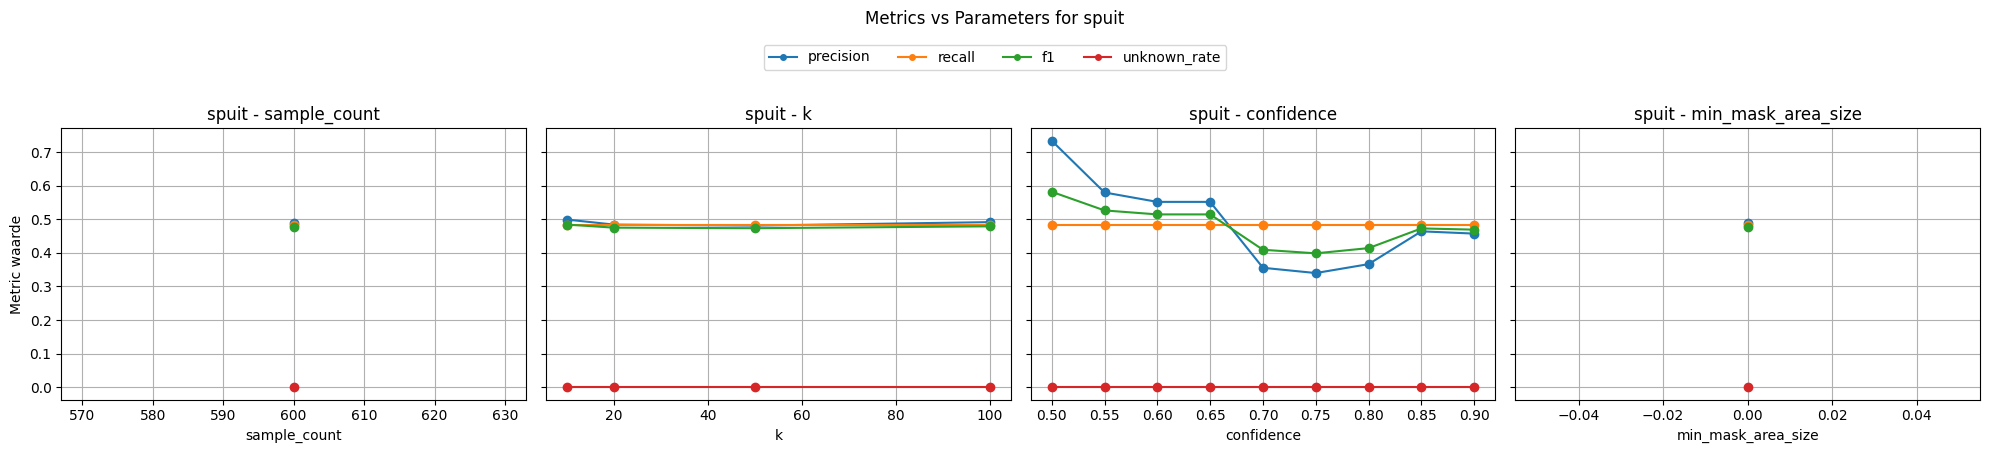

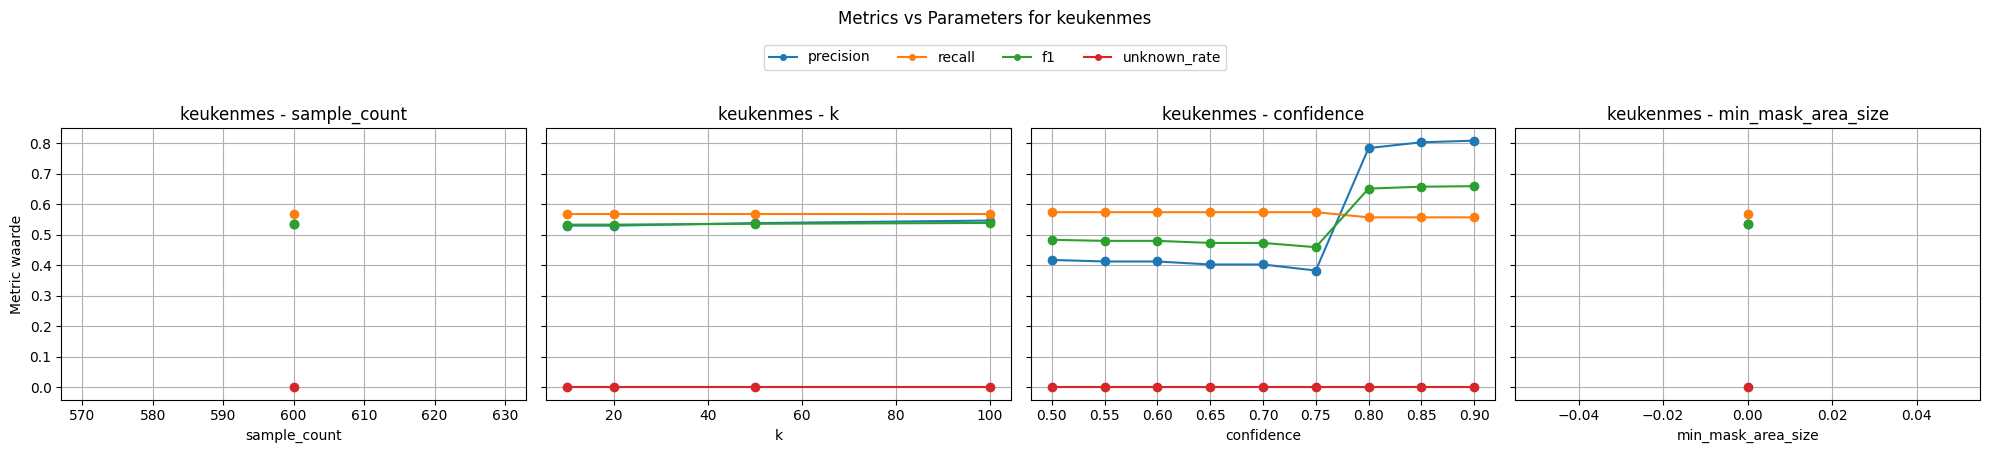

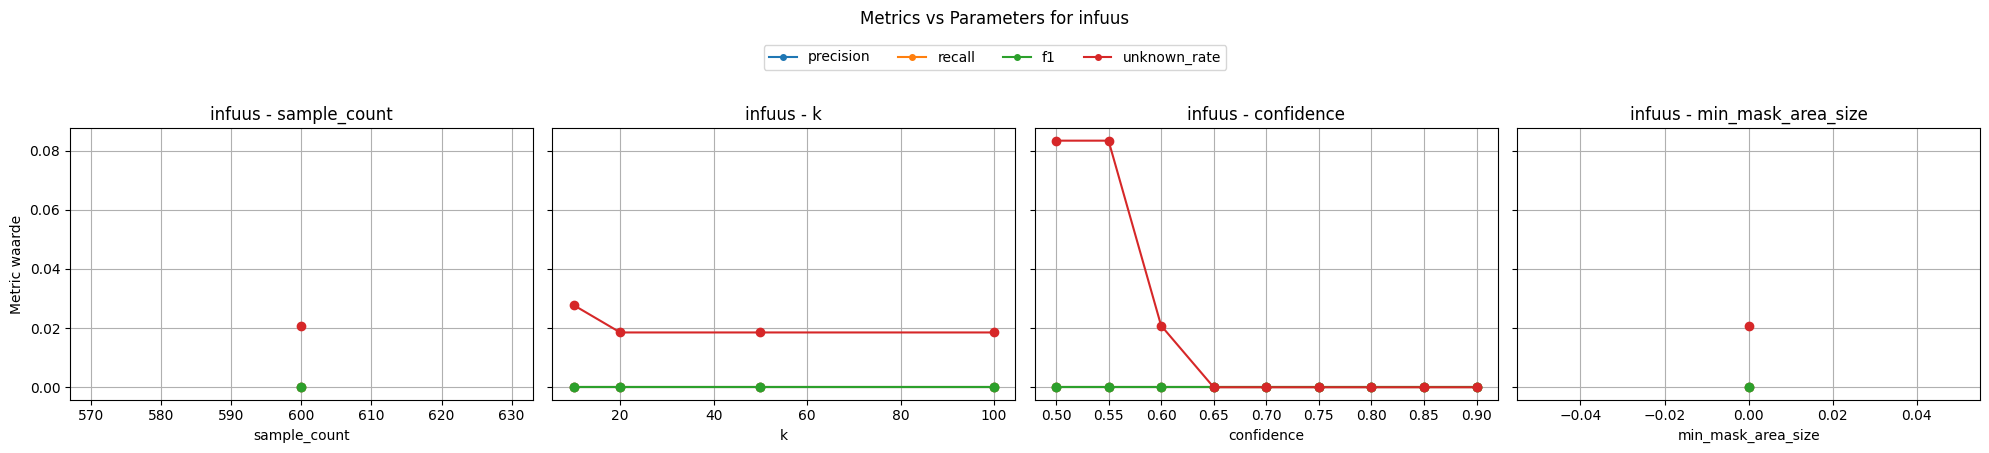

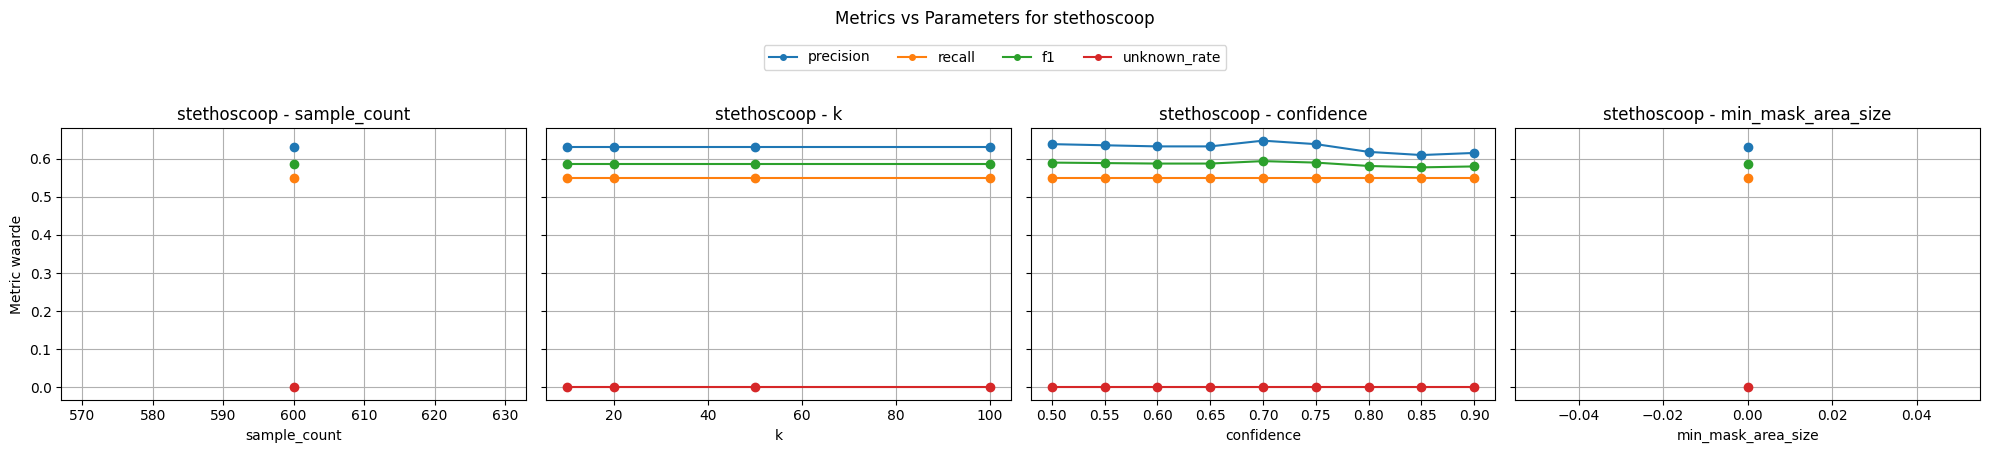

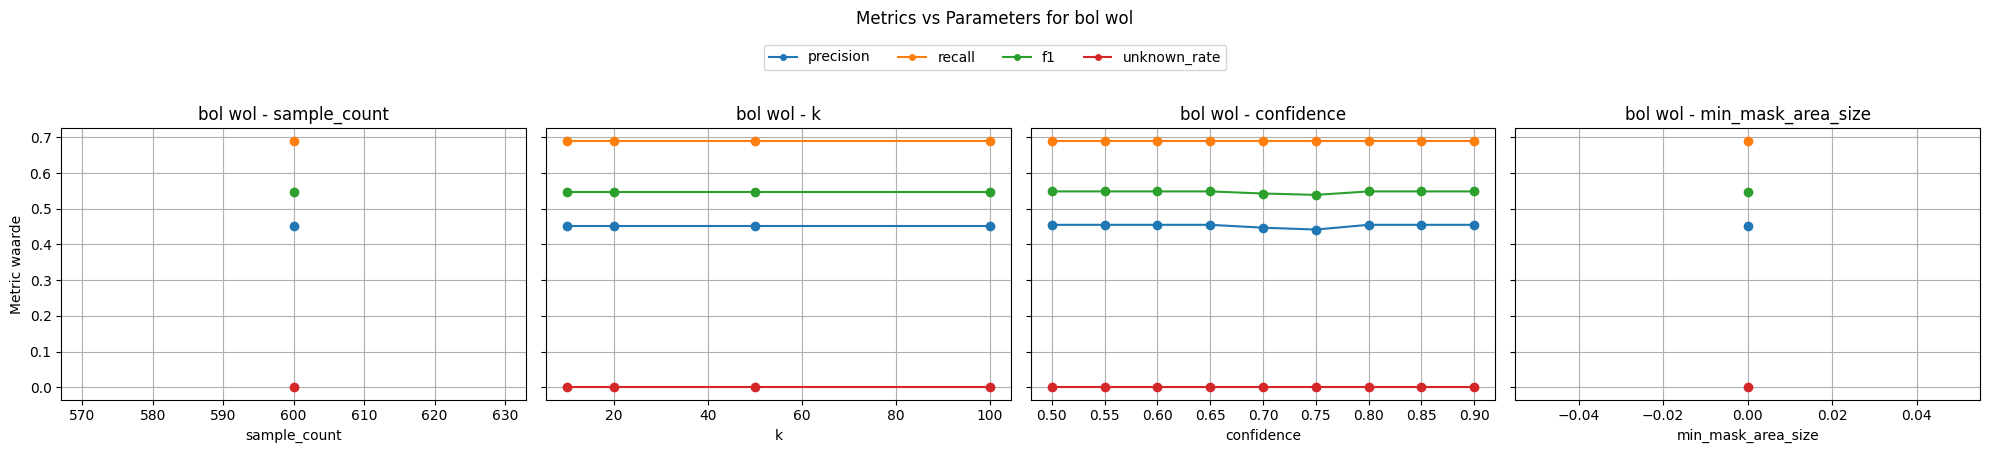

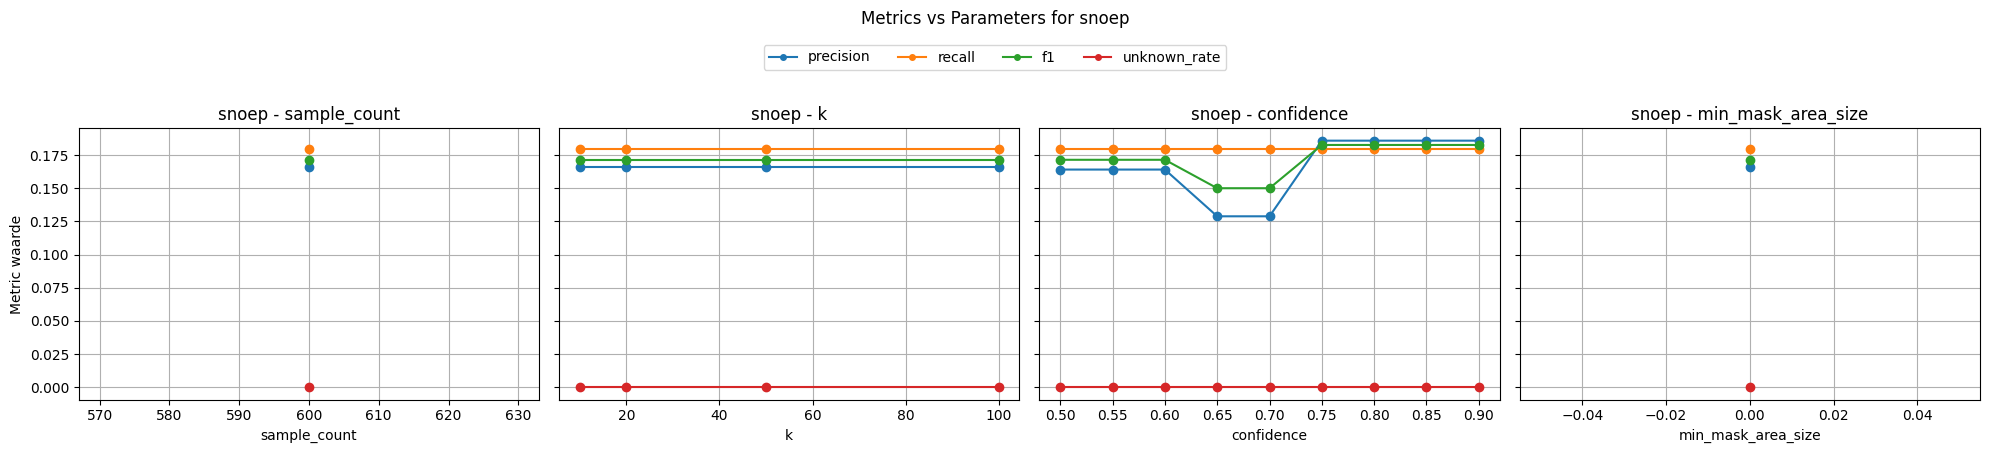

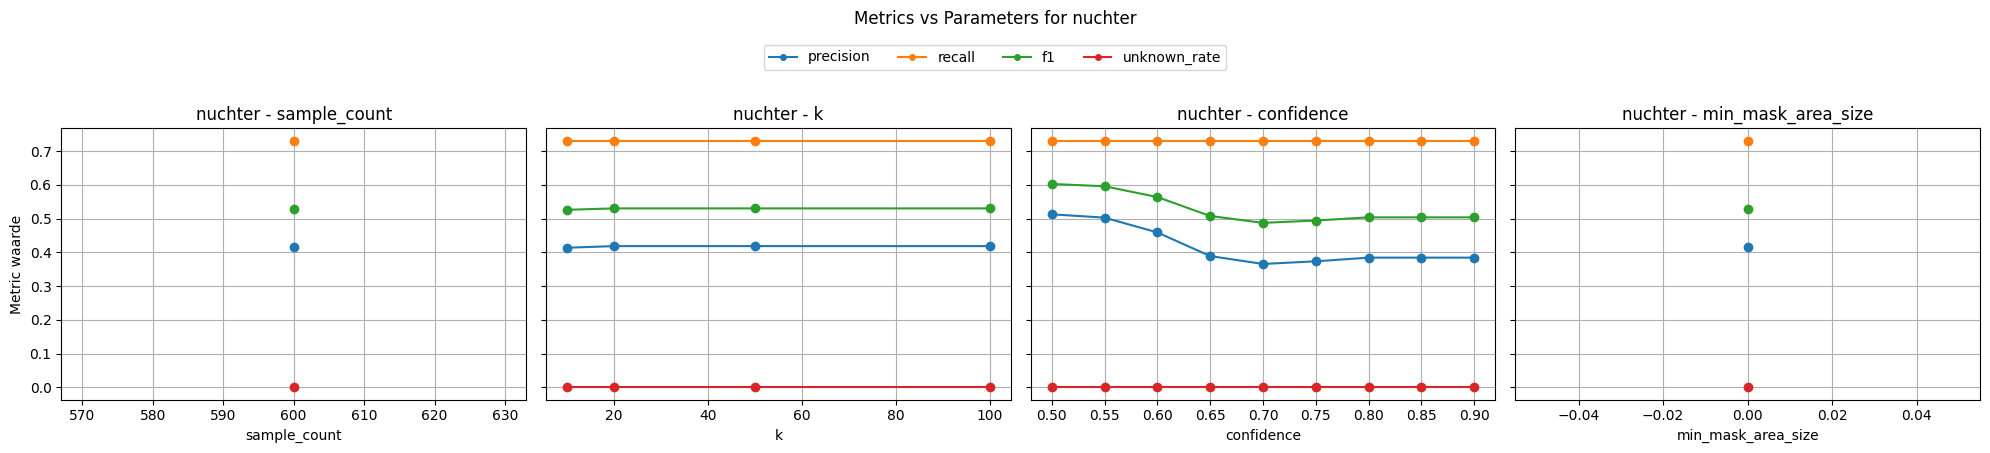

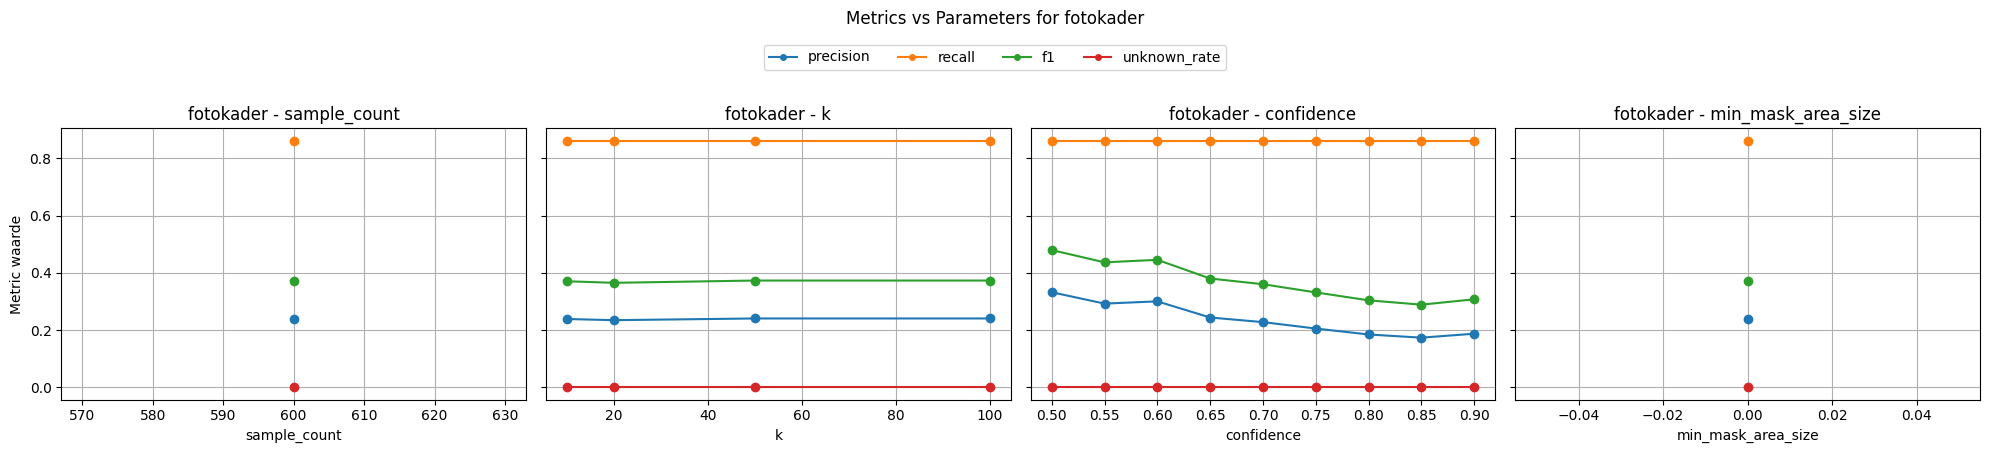

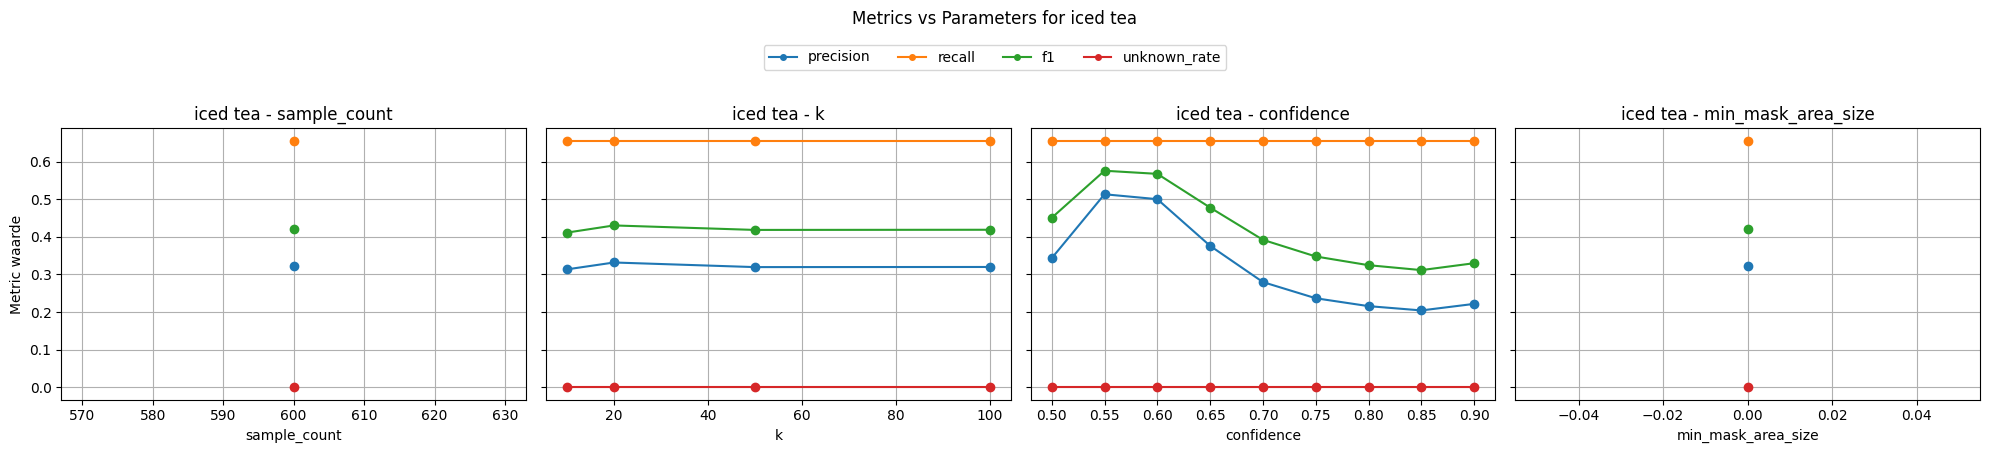

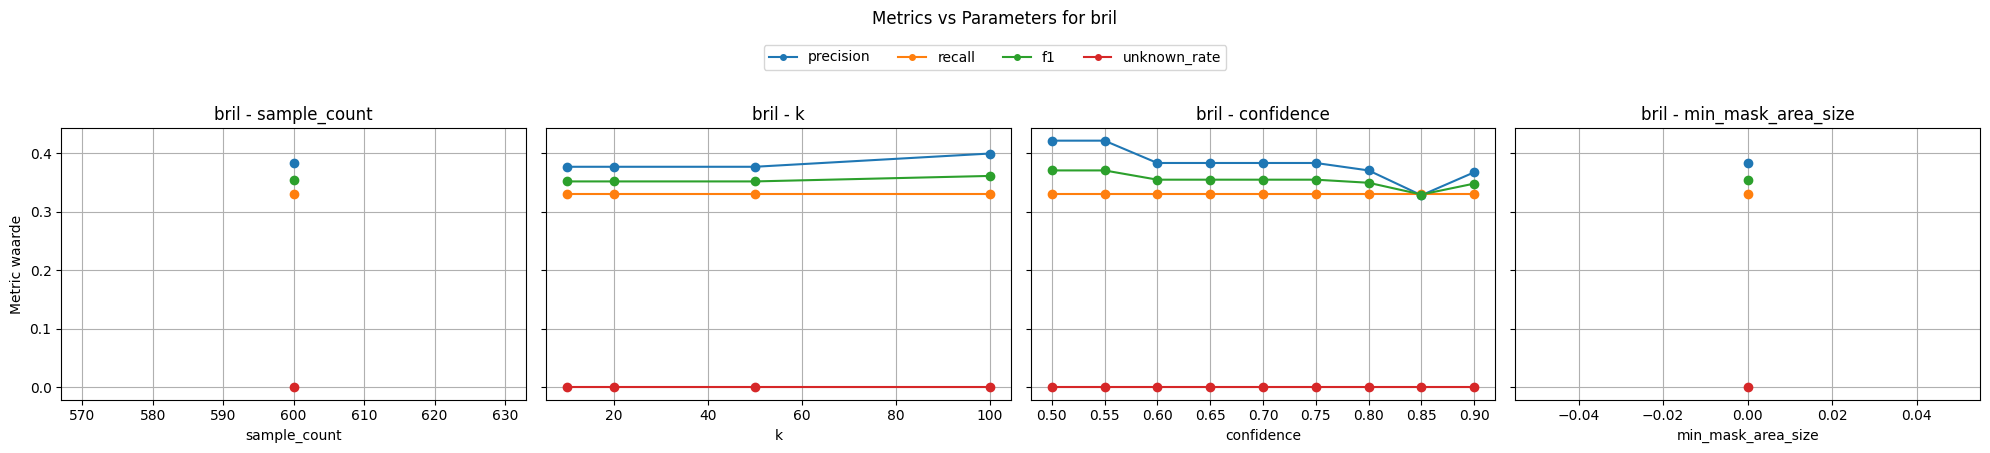

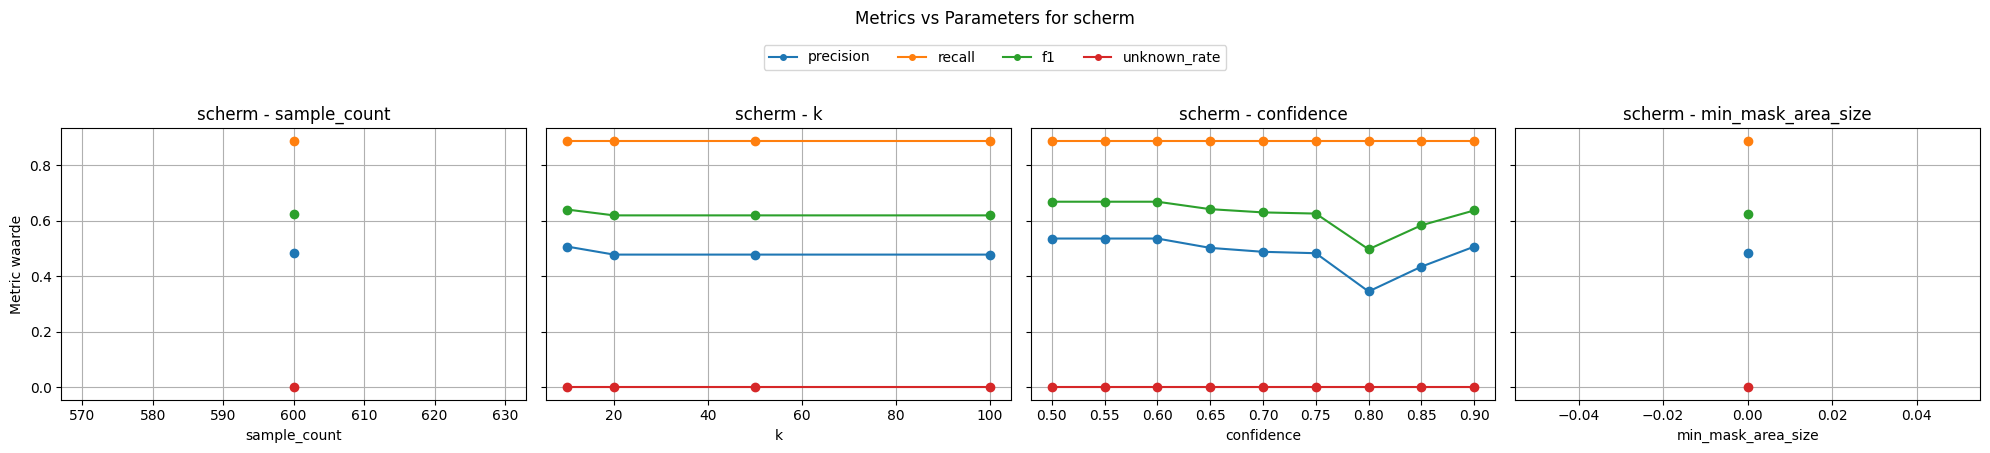

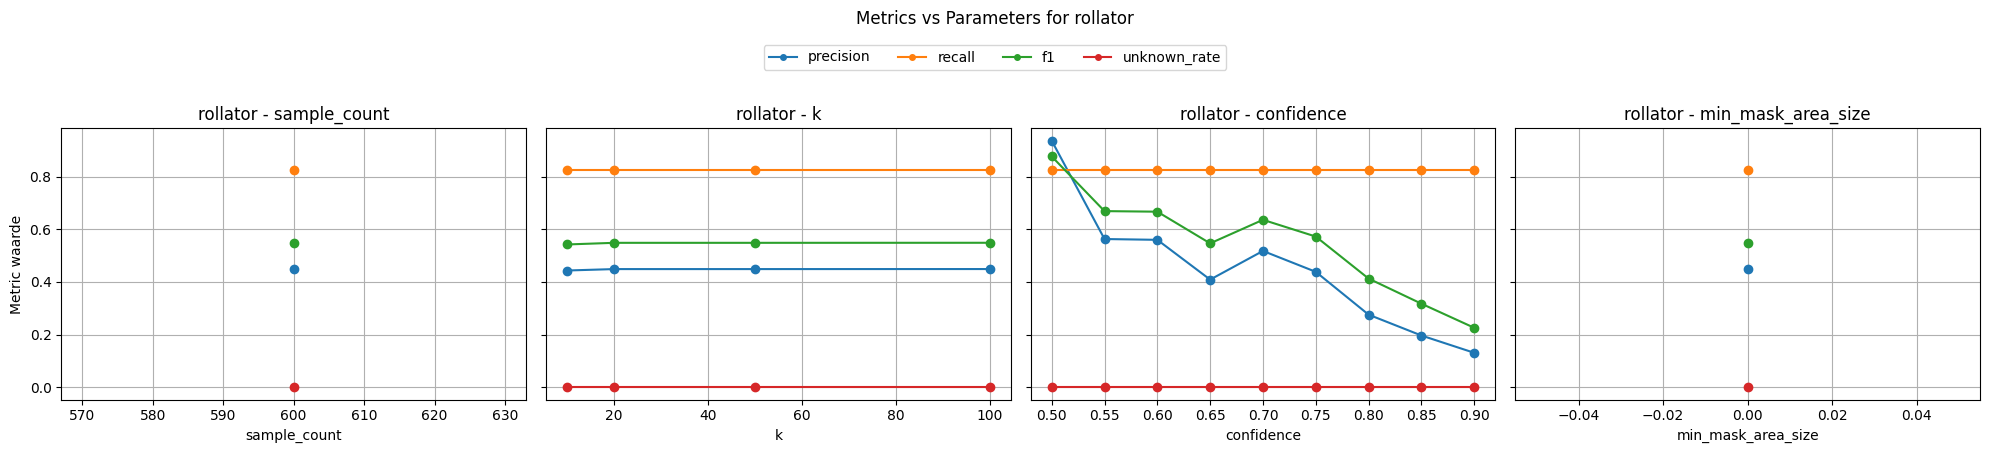

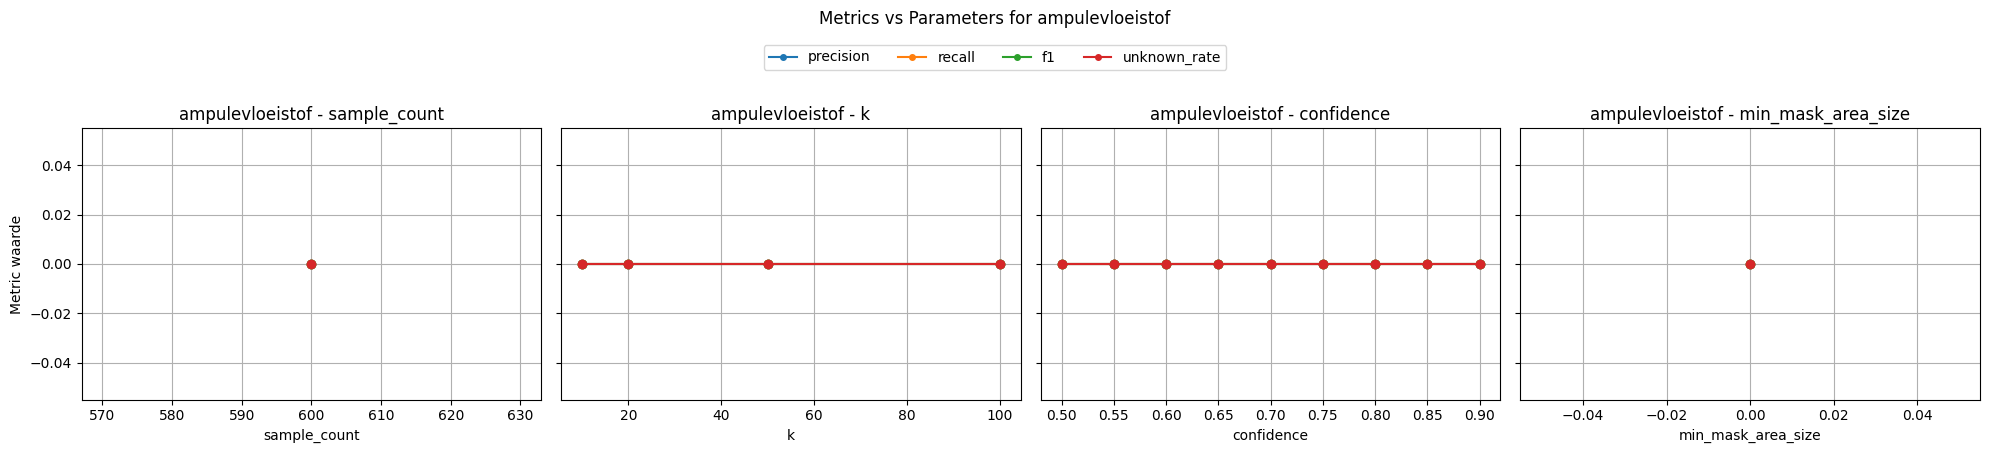

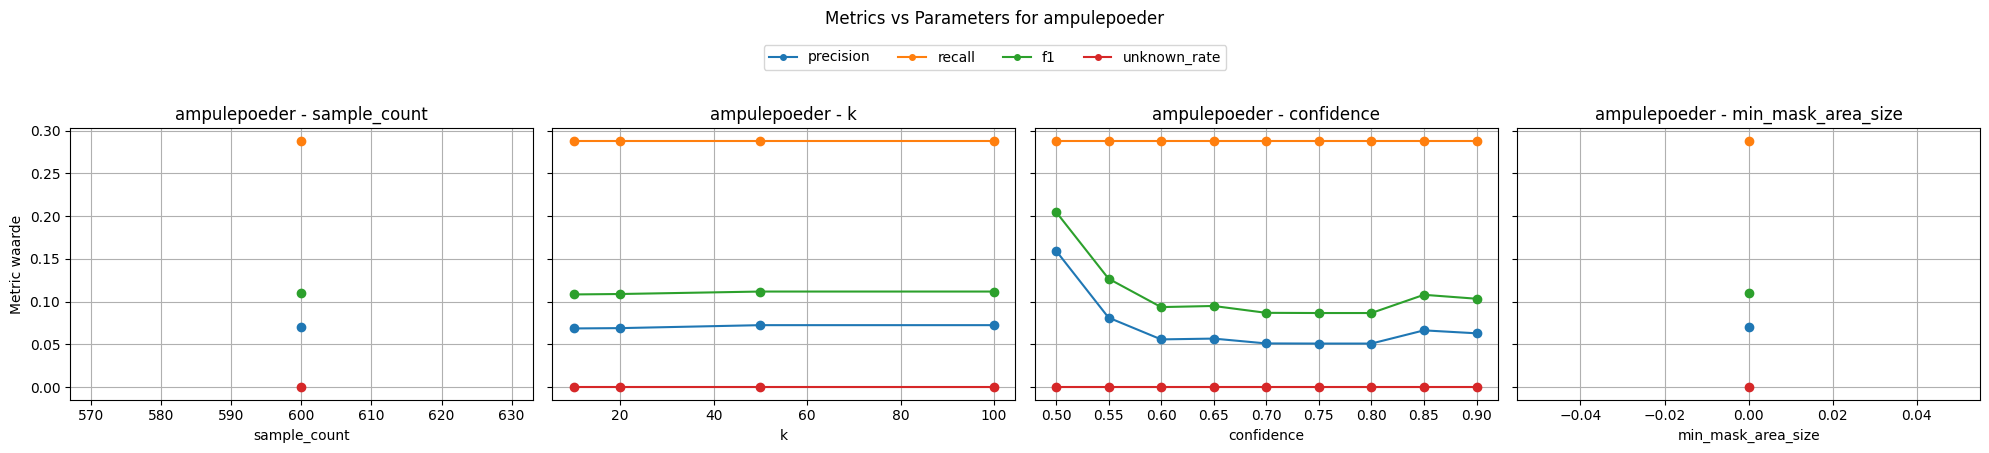

In [ ]:
import matplotlib.lines as mlines

# Definieer de grid parameters en de metrics die je wilt plotten.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metrics = ["precision", "recall", "f1", "unknown_rate"]

# Loop over elke class in de DataFrame.
for class_id in per_class_metrics_df["class_id"].unique():
    # Filter de DataFrame voor de huidige class.
    df_class = per_class_metrics_df[per_class_metrics_df["class_id"] == class_id]

    # Maak een figuur met horizontaal gestapelde subplots (één per grid parameter).
    fig, axes = plt.subplots(
        1, len(grid_params), figsize=(5 * len(grid_params), 4), sharey=True
    )

    # Zorg dat axes altijd een lijst is.
    if len(grid_params) == 1:
        axes = [axes]

    # Per subplot: groepeer op de huidige parameter en plot de lijnen voor elke metric.
    for ax, param in zip(axes, grid_params, strict=False):
        grouped = df_class.groupby(param)[metrics].mean().reset_index()

        for met in metrics:
            ax.plot(grouped[param], grouped[met], marker="o", color=color_mapping[met])

        ax.set_xlabel(param)
        ax.grid(True)
        ax.set_title(f"{CLASS_ID_TO_NAME.get(class_id, class_id)} - {param}")

    axes[0].set_ylabel("Metric waarde")

    # Maak één globale legende met vaste kleuren.
    legend_handles = []
    for met in metrics:
        line = mlines.Line2D(
            [], [], color=color_mapping[met], marker="o", markersize=4, label=met
        )
        legend_handles.append(line)

    fig.legend(
        handles=legend_handles,
        loc="upper center",
        ncol=len(metrics),
        bbox_to_anchor=(0.5, 1.05),
    )
    fig.suptitle(
        f"Metrics vs Parameters for {CLASS_ID_TO_NAME.get(class_id, class_id)}", y=1.12
    )
    plt.tight_layout()
    plt.show()

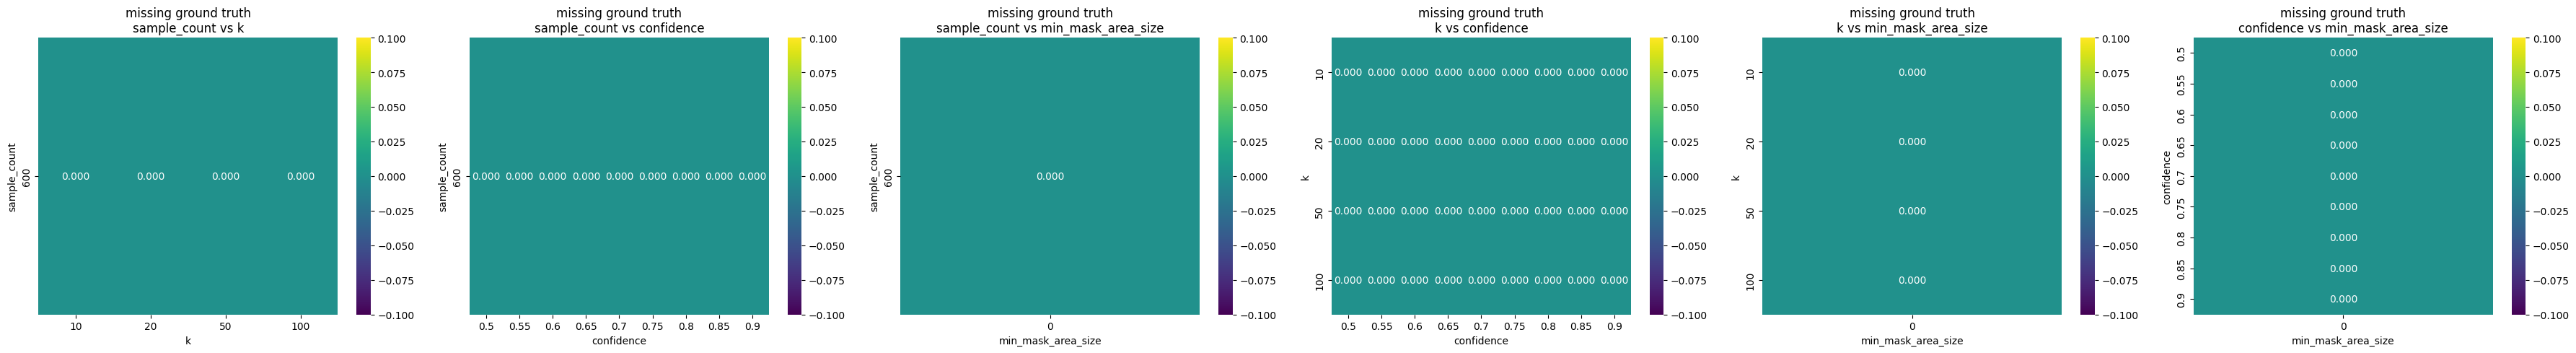

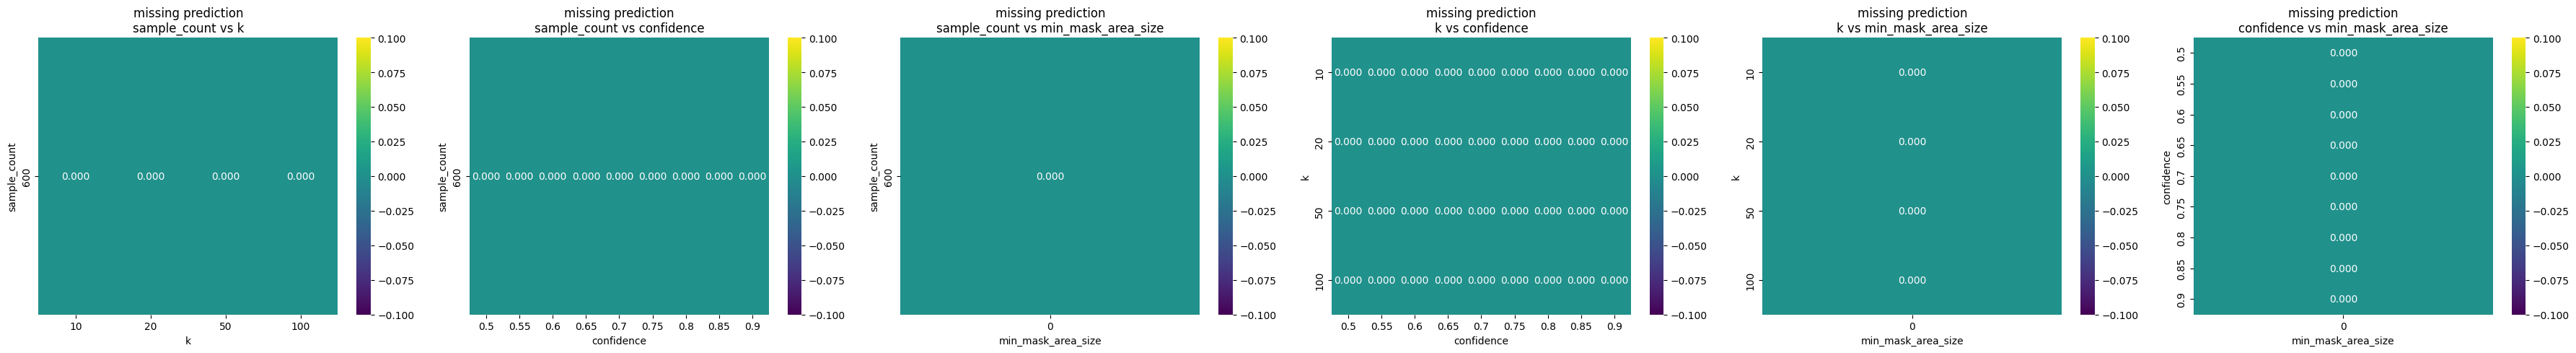

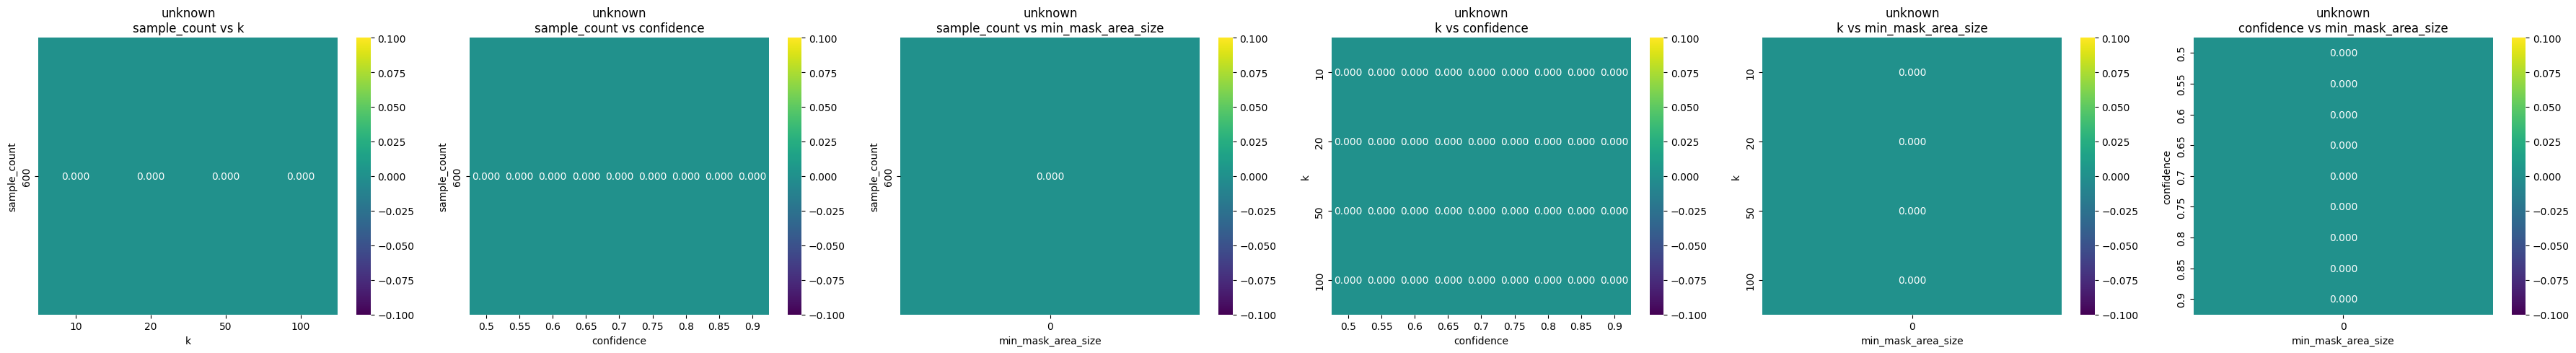

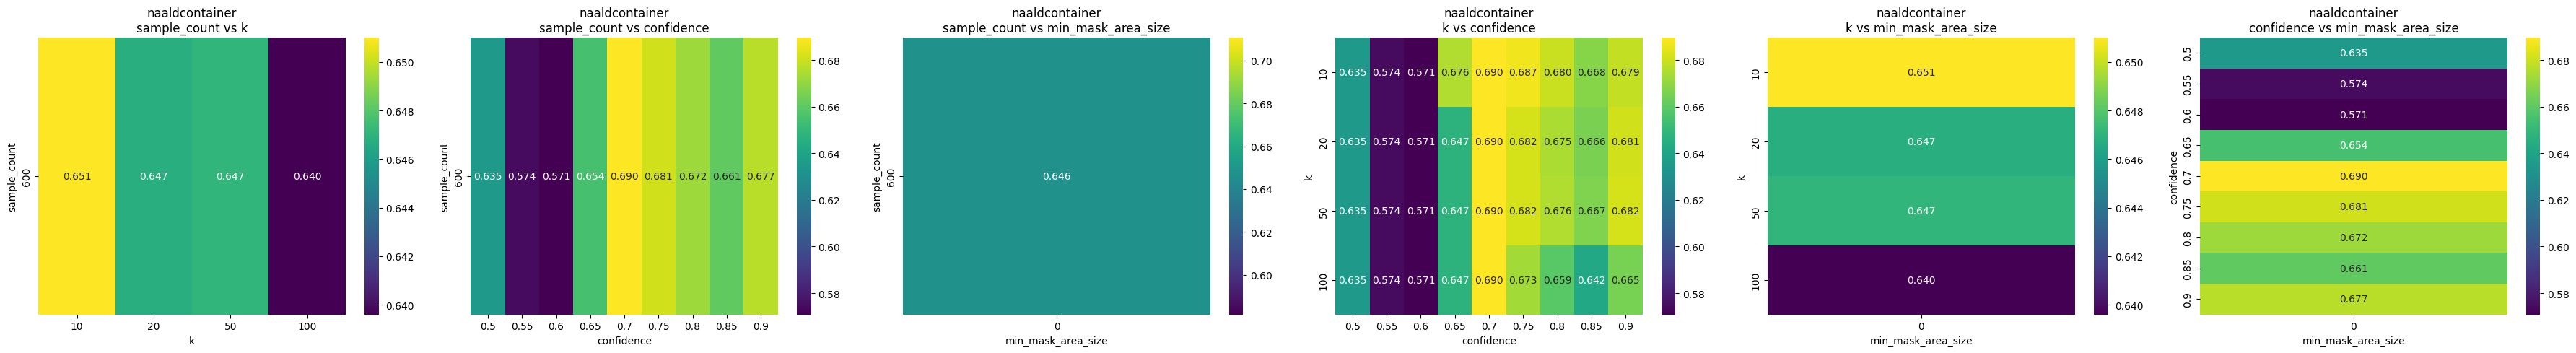

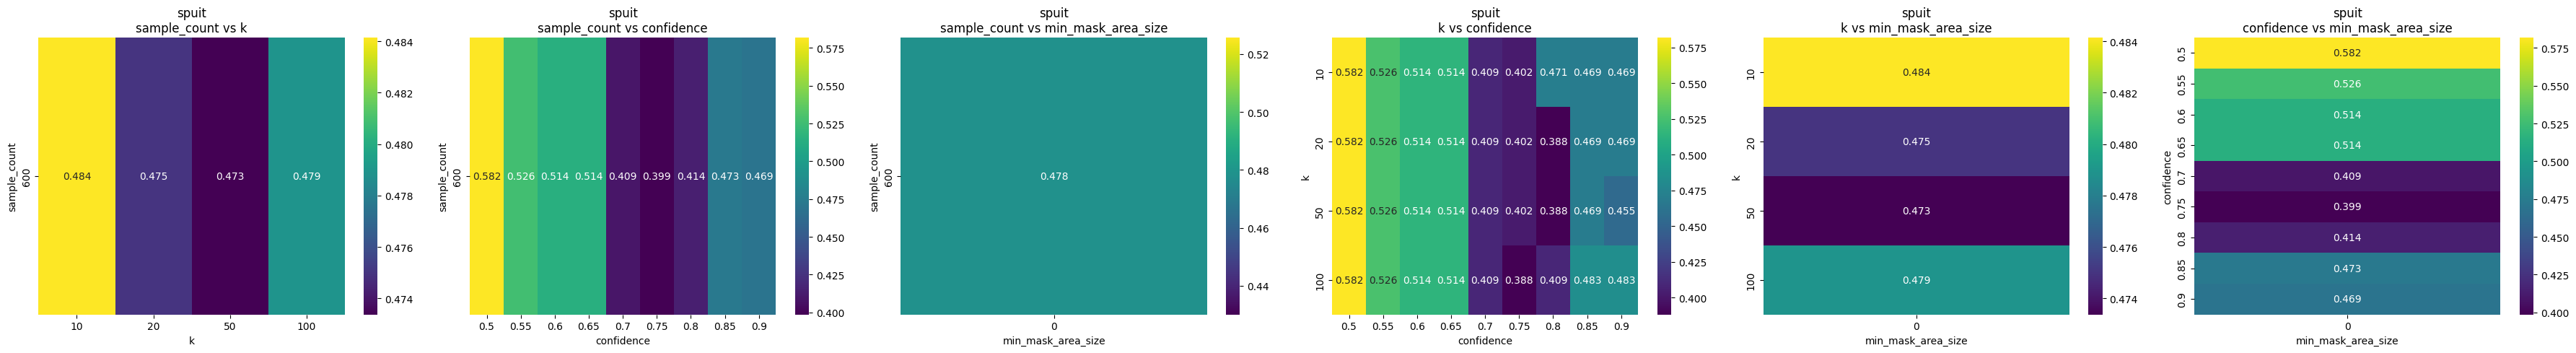

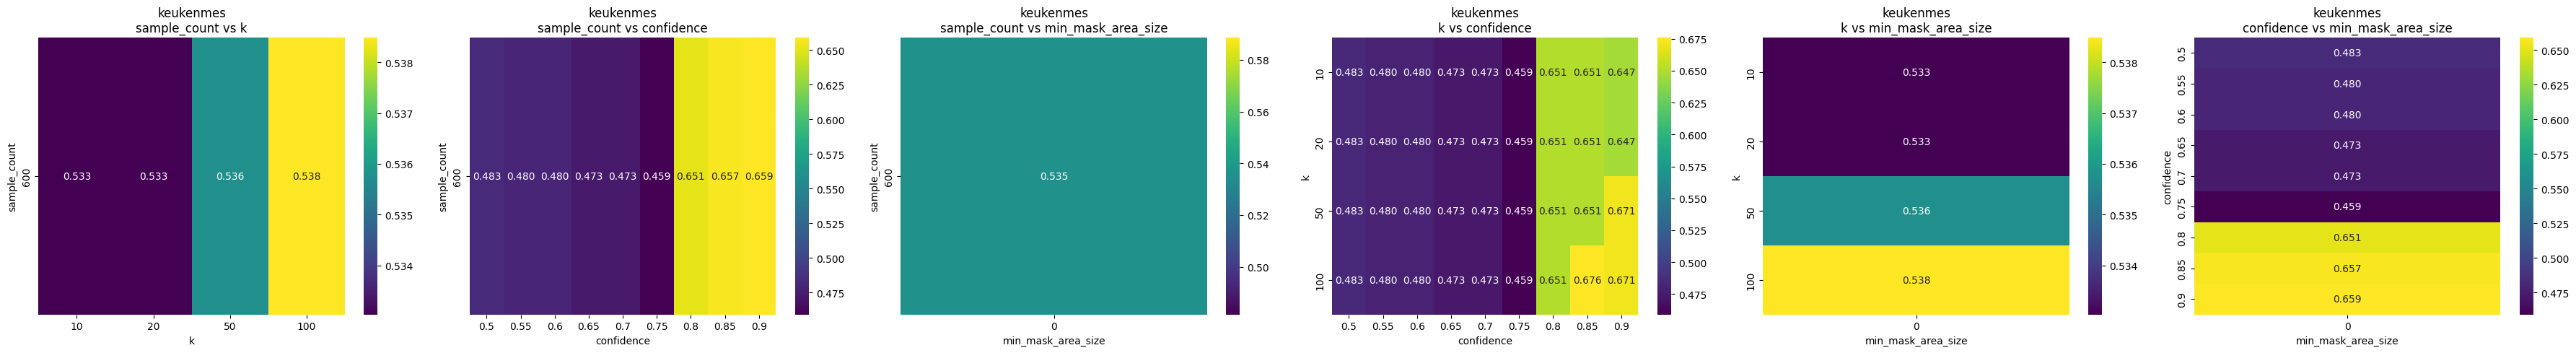

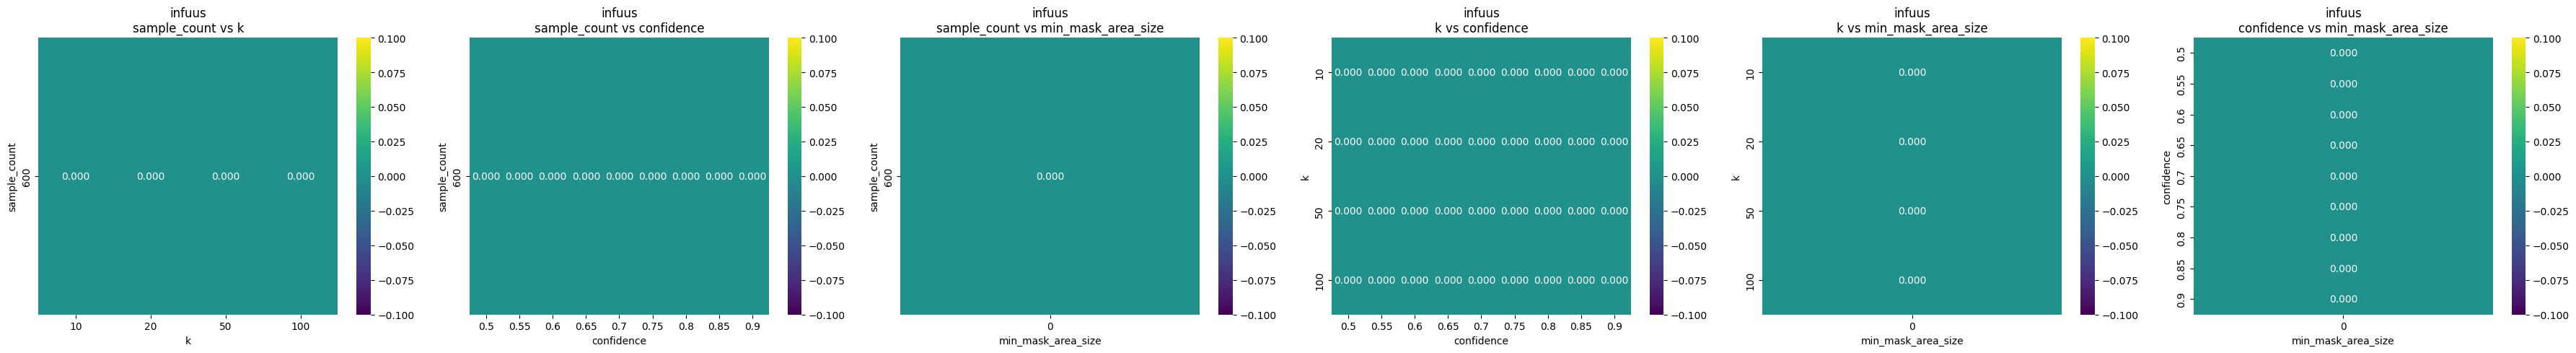

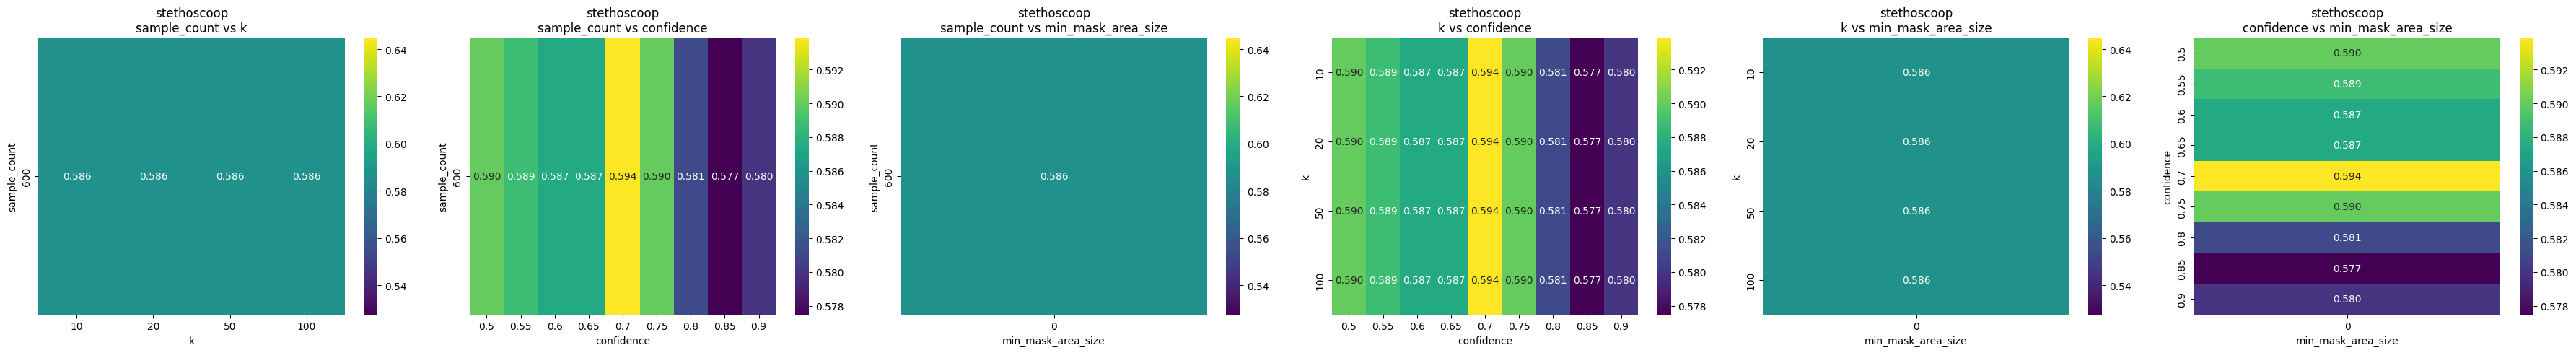

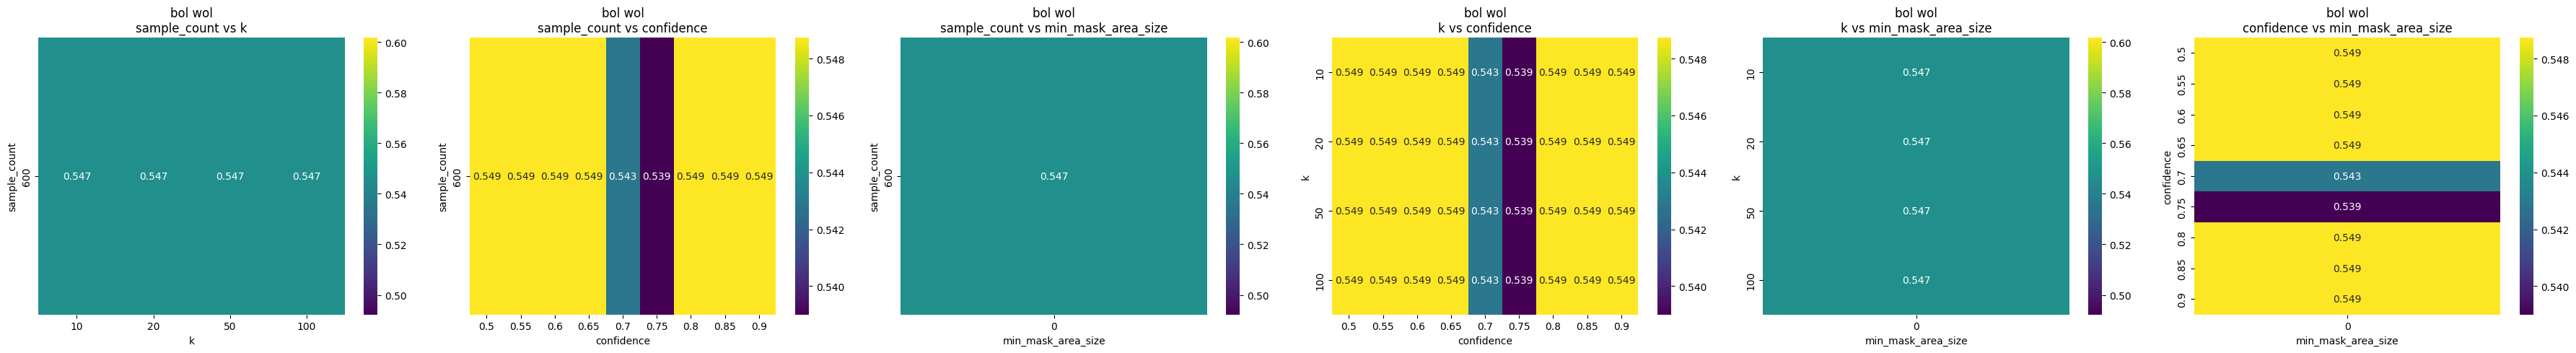

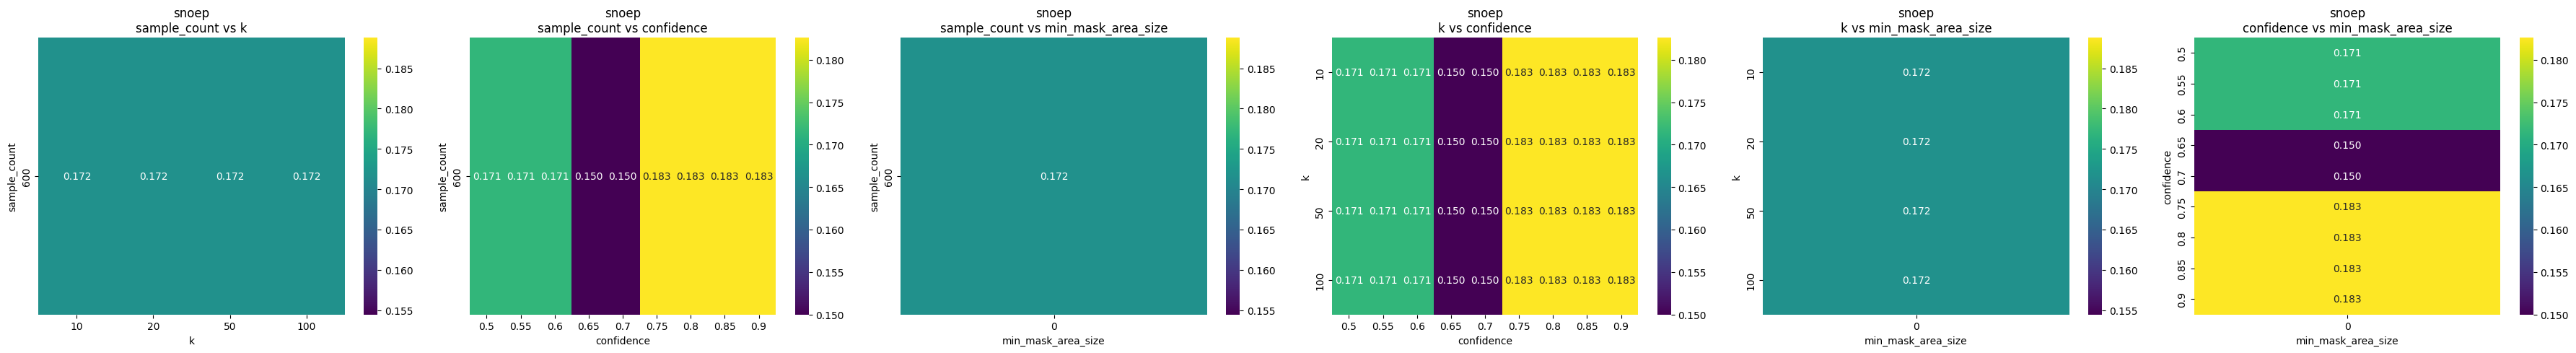

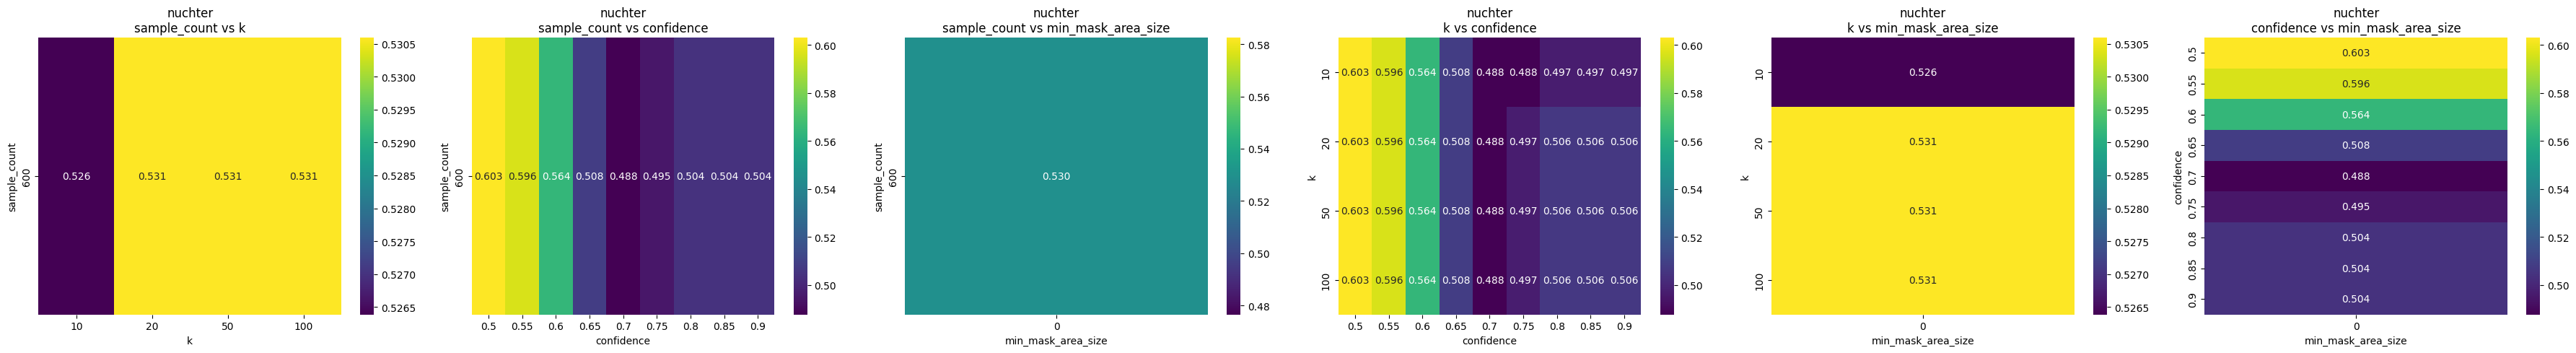

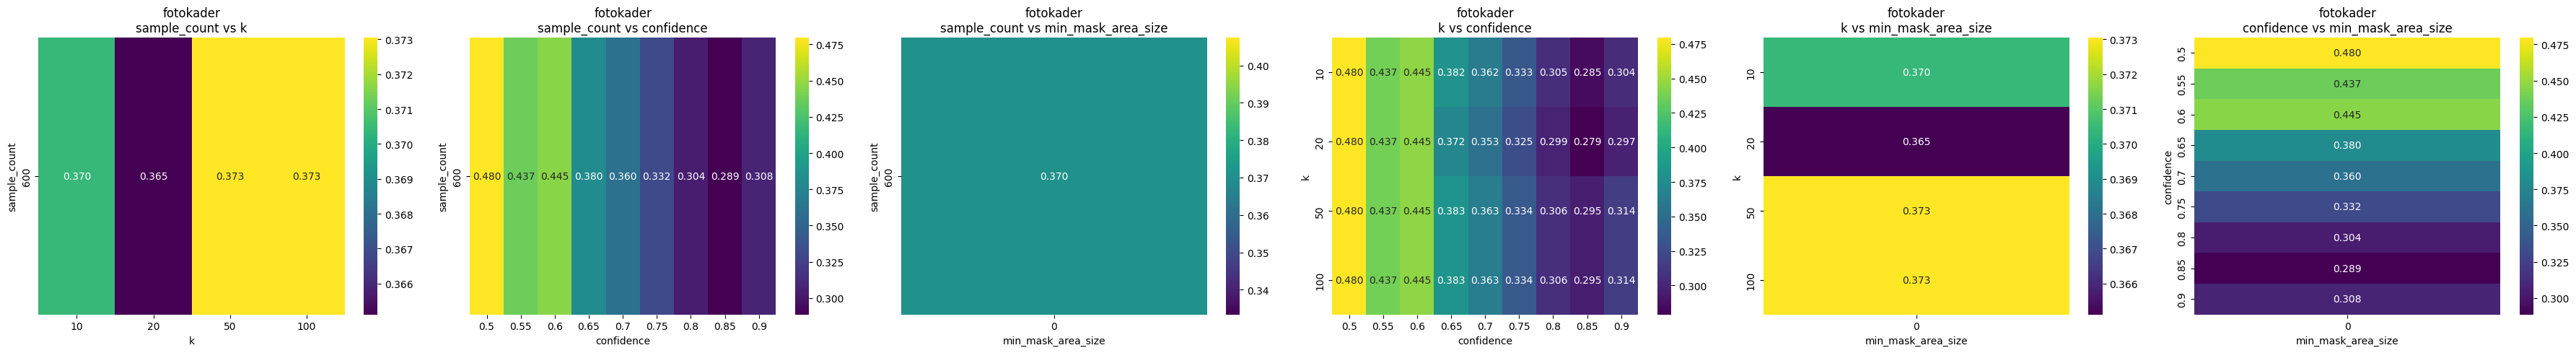

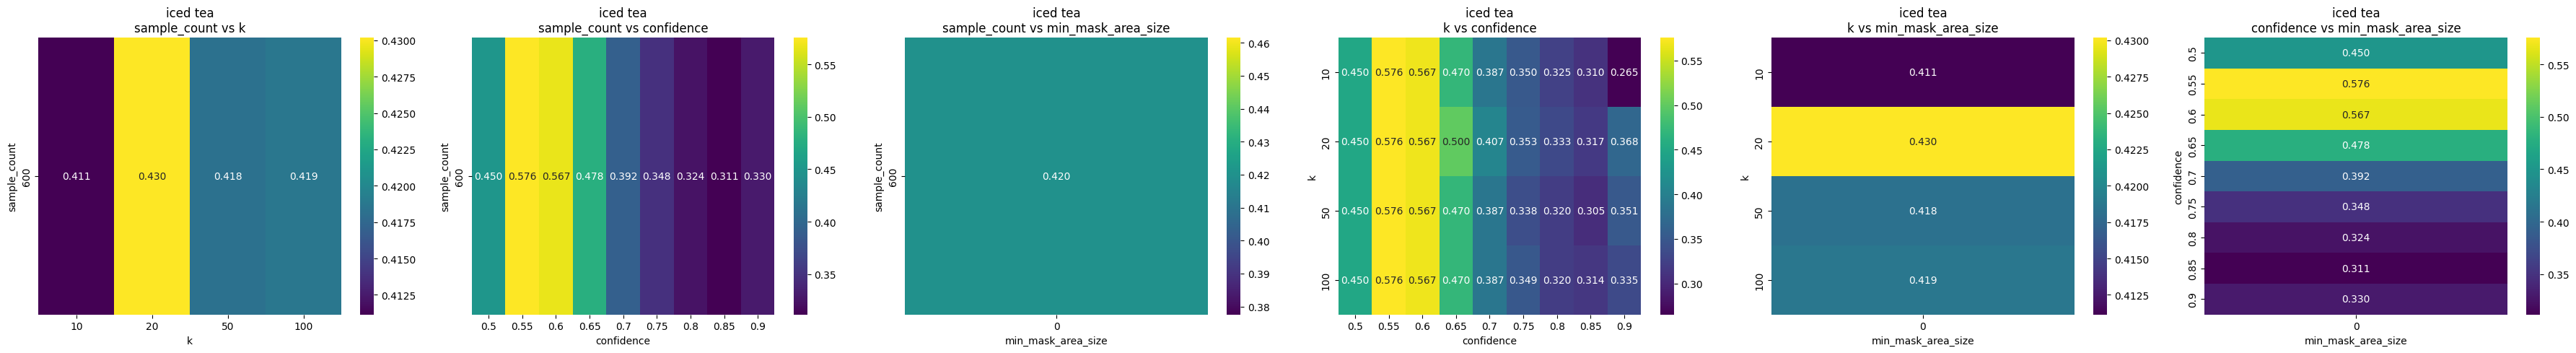

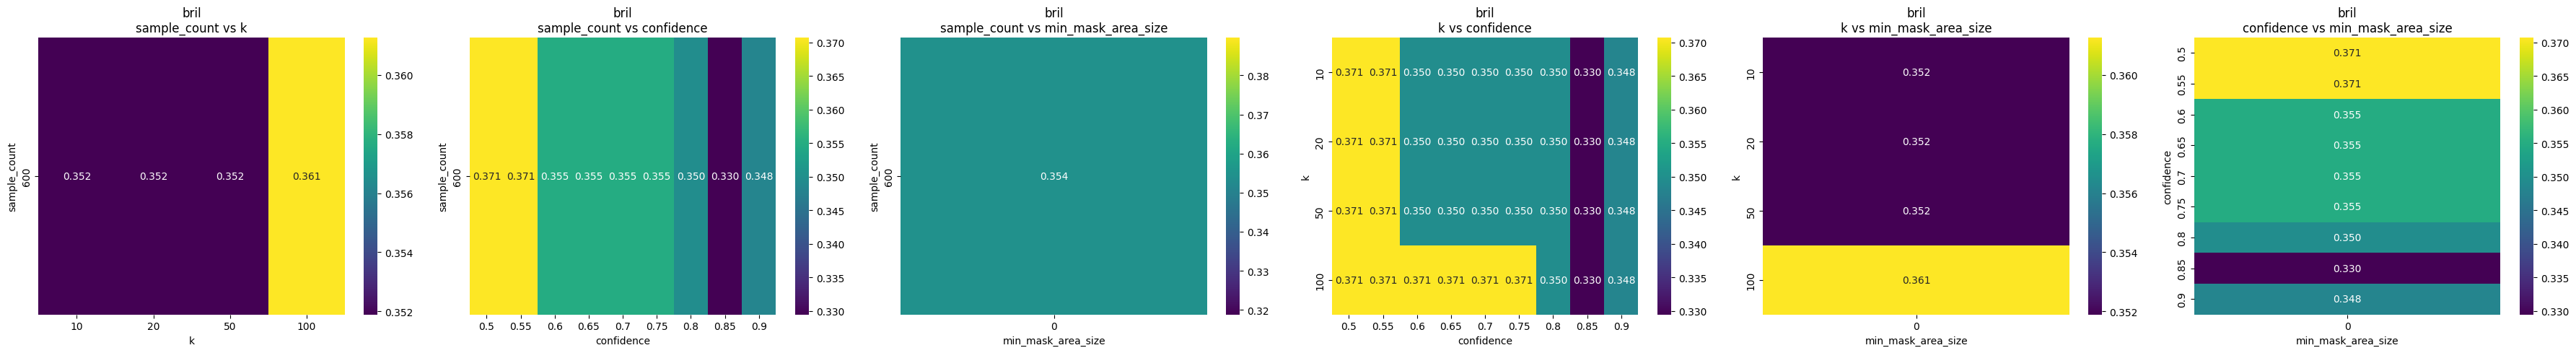

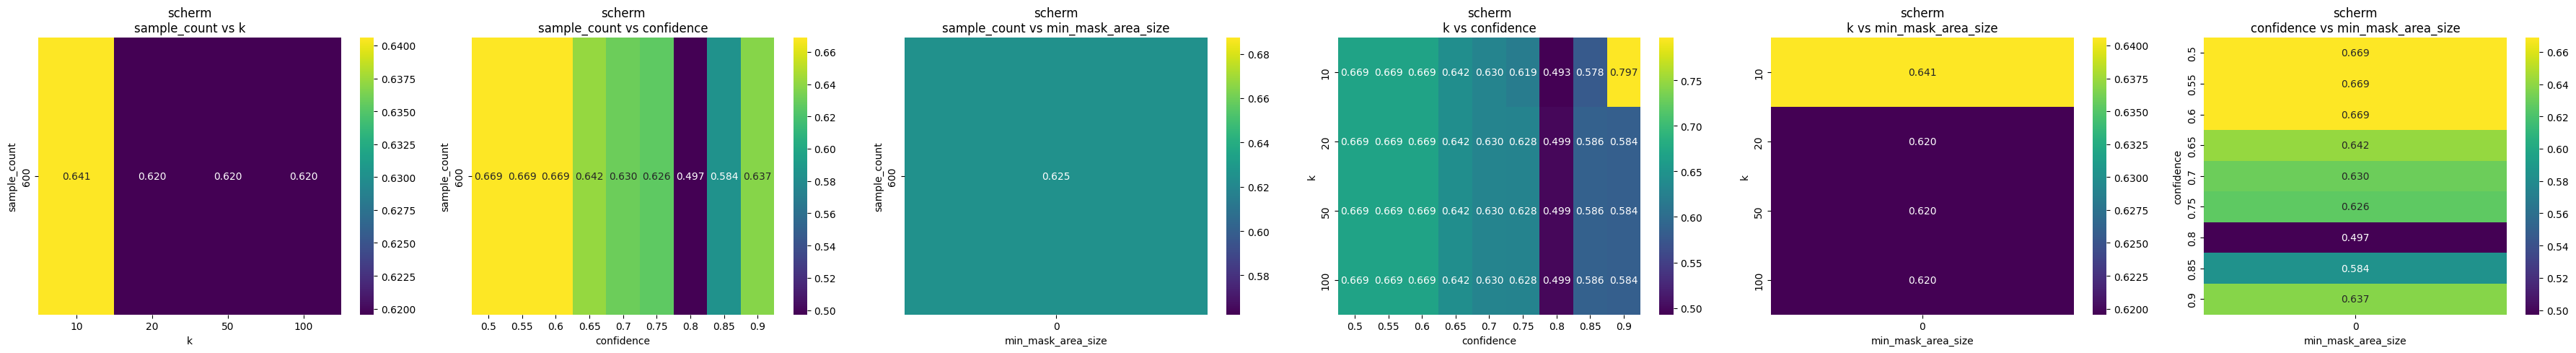

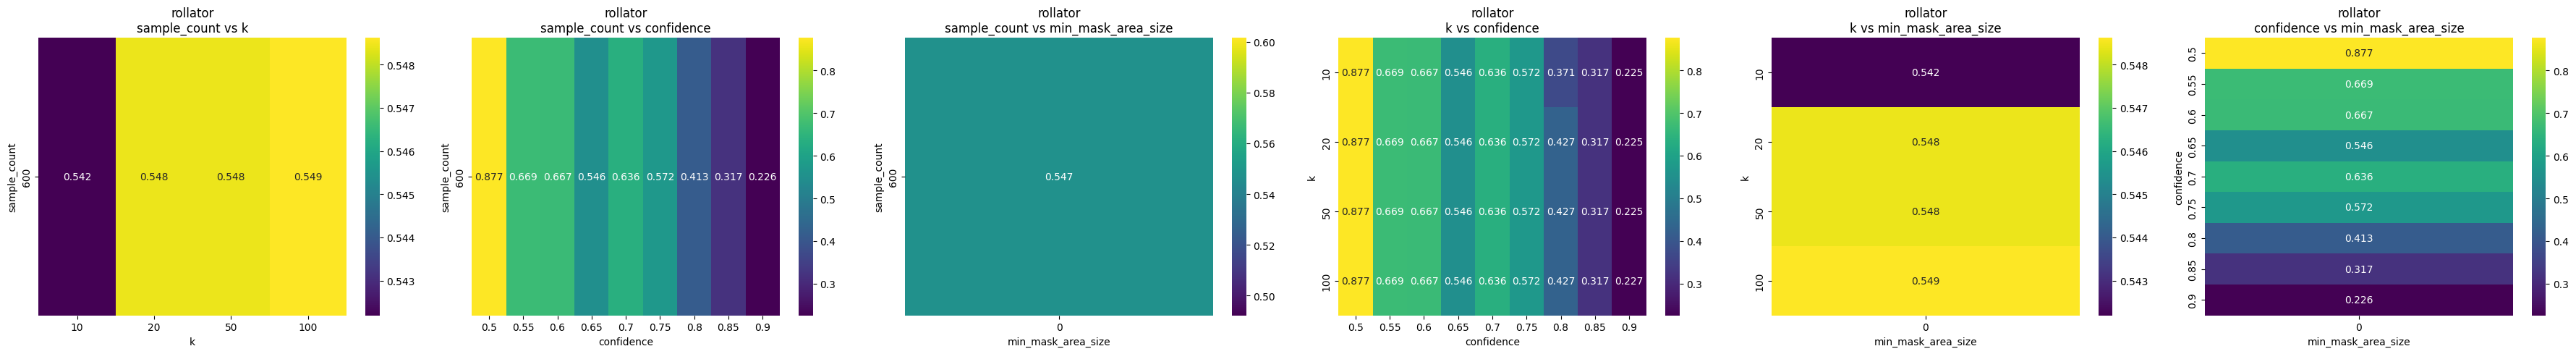

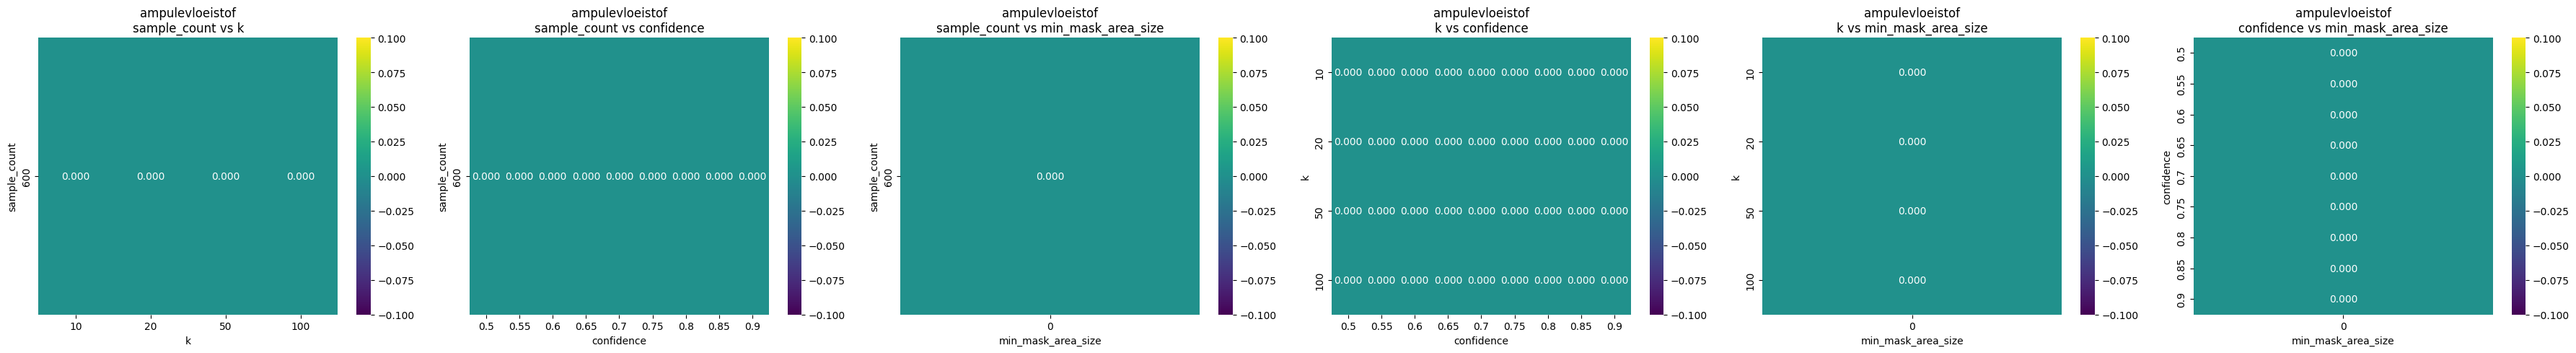

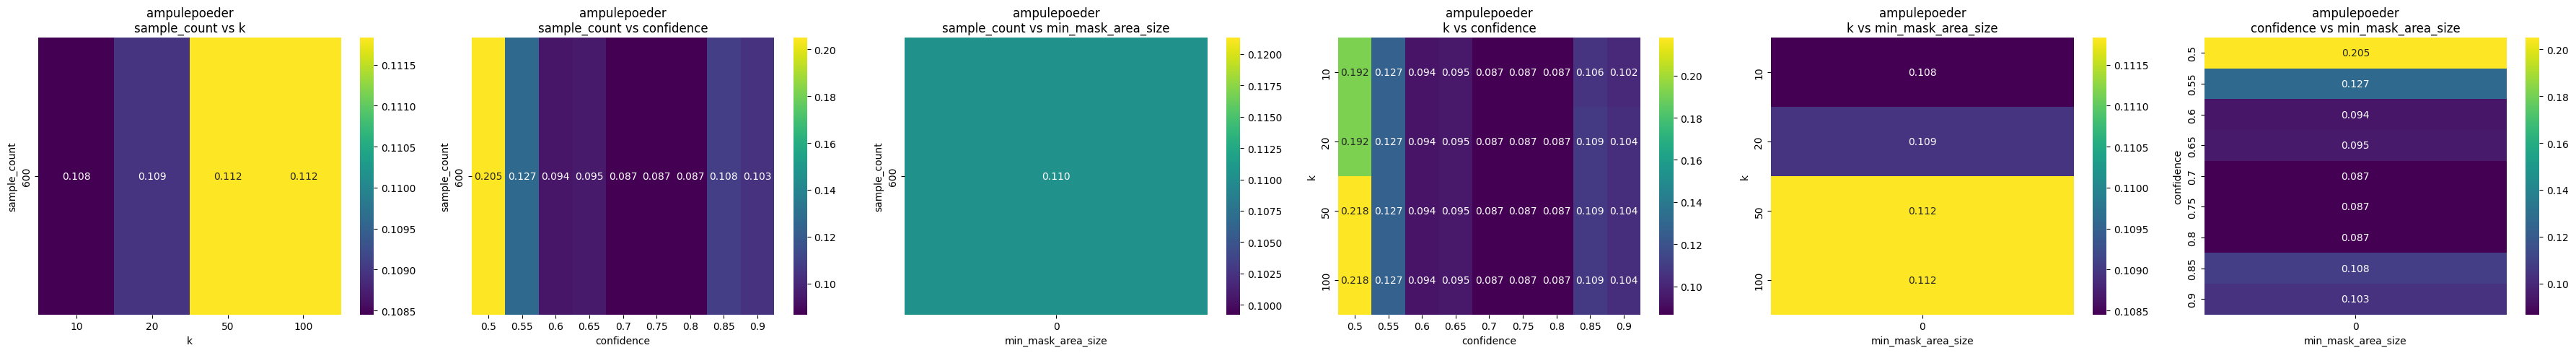

In [ ]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# List of the grid search parameter names in your DataFrame.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metric = "f1"  # Change this if you want a different metric.

# Loop through each class to generate a horizontally-stacked set of heatmaps.
for class_id in per_class_metrics_df["class_id"].unique():
    # Filter the DataFrame for the current class.
    df_class = per_class_metrics_df[per_class_metrics_df["class_id"] == class_id]

    # Generate all combinations of 2 parameters (there will be 6 combinations).
    param_combinations = list(itertools.combinations(grid_params, 2))
    n_combinations = len(param_combinations)

    # Create a figure with subplots arranged in one row.
    fig, axes = plt.subplots(1, n_combinations, figsize=(6 * n_combinations, 5))

    # If there's only one subplot, ensure axes is iterable.
    if n_combinations == 1:
        axes = [axes]

    # Loop over each parameter pair and corresponding subplot axis.
    for ax, (x_param, y_param) in zip(axes, param_combinations, strict=False):
        # Create a pivot table with the average of the metric for each combination.
        pivot_table = pd.pivot_table(
            df_class, values=metric, index=x_param, columns=y_param, aggfunc="mean"
        )
        # Plot the heatmap.
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", ax=ax)

        # Get a descriptive class name from the mapping, if available.
        class_name = CLASS_ID_TO_NAME.get(class_id, class_id)
        ax.set_title(f"{class_name}\n{x_param} vs {y_param}")
        ax.set_xlabel(y_param)
        ax.set_ylabel(x_param)

    plt.tight_layout()
    plt.show()

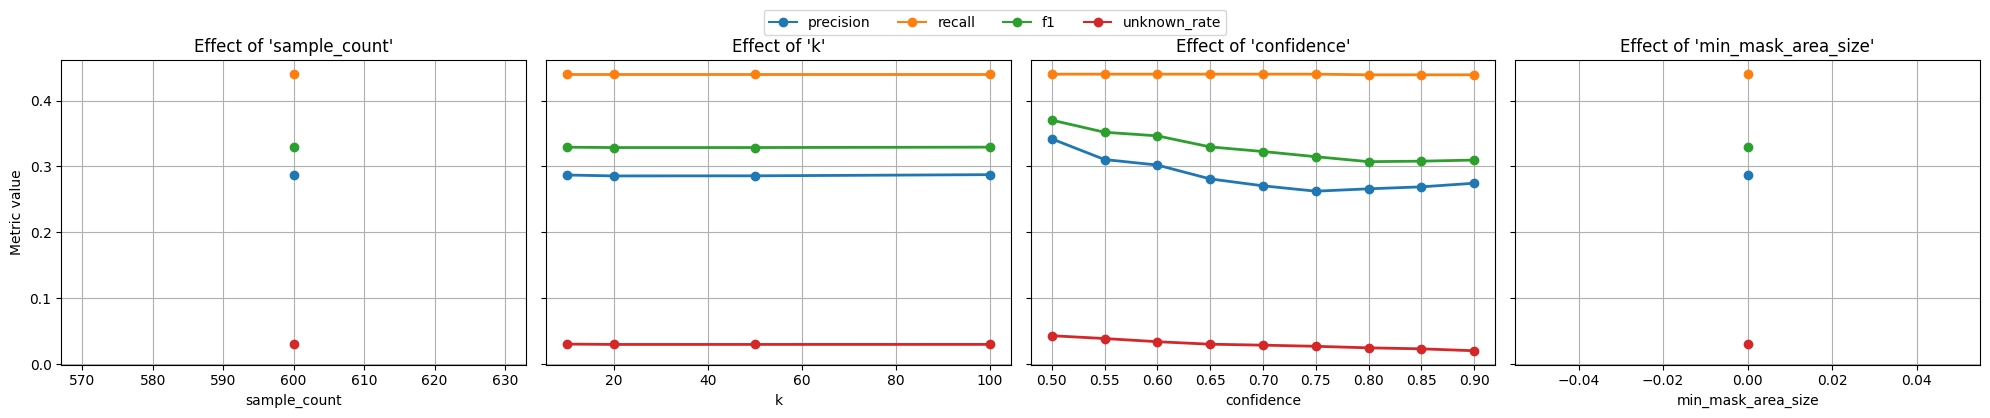

In [ ]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd

# Define grid parameters and metrics for analysis.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metrics = ["precision", "recall", "f1", "unknown_rate"]

# Create a figure with horizontally stacked subplots (one per grid parameter).
fig, axes = plt.subplots(
    1, len(grid_params), figsize=(5 * len(grid_params), 4), sharey=True
)

# Ensure 'axes' is always an iterable list.
if len(grid_params) == 1:
    axes = [axes]

# For each grid parameter: group the data by unique parameter value and calculate the average of the metrics.
for ax, param in zip(axes, grid_params, strict=False):
    # Aggregate metrics by parameter value (average across all combinations and classes)
    grouped = per_class_metrics_df.groupby(param)[metrics].mean().reset_index()

    # For each metric: create a line plot on the current axis.
    for met in metrics:
        ax.plot(
            grouped[param],
            grouped[met],
            marker="o",
            color=color_mapping[met],
            label=met,  # The same label name repeated, but we'll create a single global legend.
            linewidth=2,
        )

    ax.set_xlabel(param)
    ax.set_title(f"Effect of '{param}'")
    ax.grid(True)

# Set the common y-axis label.
axes[0].set_ylabel("Metric value")

# Create one global legend with fixed color indicators.
legend_handles = []
for met in metrics:
    handle = mlines.Line2D(
        [],
        [],
        color=color_mapping[met],
        marker="o",
        linestyle="-",
        markersize=6,
        label=met,
    )
    legend_handles.append(handle)

fig.legend(
    handles=legend_handles,
    loc="upper center",
    ncol=len(metrics),
    bbox_to_anchor=(0.5, 1.05),
)

plt.tight_layout()
plt.show()

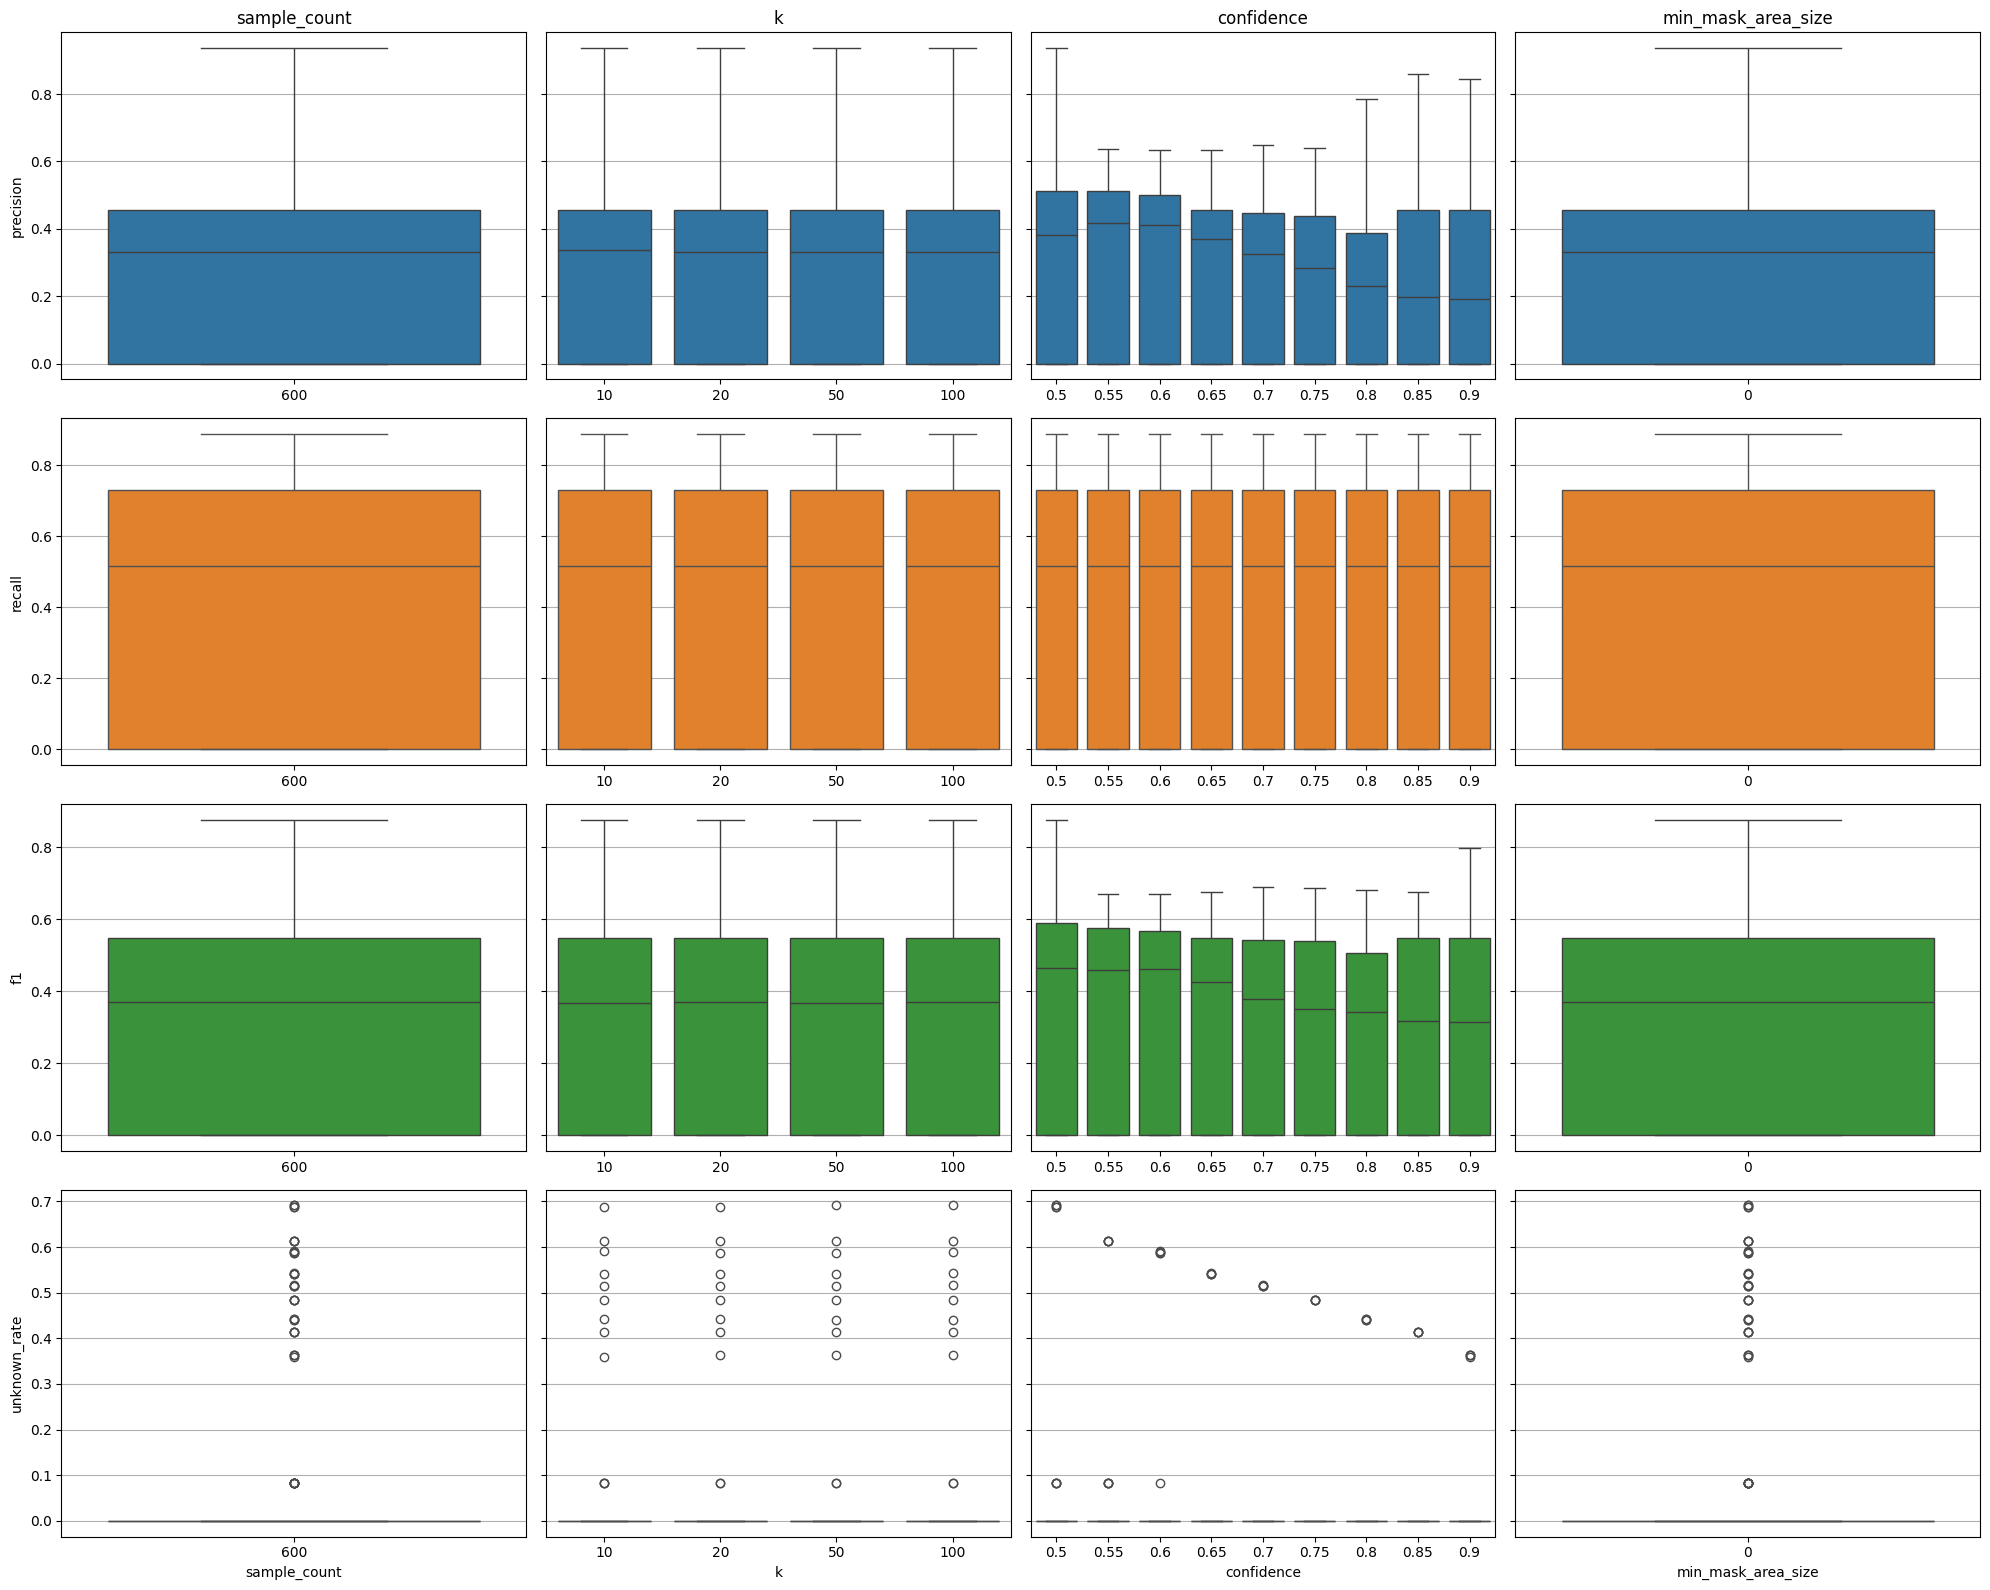

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the grid parameters (columns) and the metrics (rows) to plot.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metrics_to_plot = ["precision", "recall", "f1", "unknown_rate"]


# Create a figure with subplots: rows = number of metrics, columns = number of parameters.
num_rows = len(metrics_to_plot)
num_cols = len(grid_params)
fig, axes = plt.subplots(
    nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows), sharey="row"
)

# Loop over each metric (for rows) and each grid parameter (for columns).
for i, metric in enumerate(metrics_to_plot):
    for j, param in enumerate(grid_params):
        ax = axes[i, j]
        # Create a boxplot: the x-axis is the grid parameter (all unique values)
        # and the y-axis is the metric. The color of the box is set according to the metric.
        sns.boxplot(
            x=param,
            y=metric,
            data=per_class_metrics_df,
            ax=ax,
            color=color_mapping[metric],
        )

        # Label the y-axis for the left column only.
        if j == 0:
            ax.set_ylabel(metric)
        else:
            ax.set_ylabel("")

        # Set the x-axis label in the bottom row.
        if i == num_rows - 1:
            ax.set_xlabel(param)
        else:
            ax.set_xlabel("")

        # For the top row, add a title to indicate which parameter is plotted.
        if i == 0:
            ax.set_title(f"{param}")

        # Optionally, add a y-axis grid for better readability.
        ax.grid(True, axis="y")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Stel dat best_keys_df al is gedefinieerd zoals eerder:
best_keys_df = per_class_metrics_df.copy()
best_keys_df = best_keys_df.loc[best_keys_df.groupby("class_id")["f1"].idxmax()].copy()
best_keys_df["class_name"] = best_keys_df["class_id"].apply(
    lambda cid: CLASS_ID_TO_NAME.get(cid, cid)
)
best_keys_df.sort_values("class_name", inplace=True)

selected_columns = [
    "class_id",
    "class_name",
    "sample_count",
    "k",
    "confidence",
    "min_mask_area_size",
    "precision",
    "recall",
    "f1",
    "unknown_rate",
]

# Definieer kolom-breedtes
col_widths = {
    "class_id": 10,
    "class_name": 20,
    "sample_count": 15,
    "k": 5,
    "confidence": 12,
    "min_mask_area_size": 20,
    "precision": 10,
    "recall": 10,
    "f1": 10,
    "unknown_rate": 15,
}

# Maak een header
header = (
    f"{'class_id':<{col_widths['class_id']}} "
    f"{'class_name':<{col_widths['class_name']}} "
    f"{'sample_count':<{col_widths['sample_count']}} "
    f"{'k':<{col_widths['k']}} "
    f"{'confidence':<{col_widths['confidence']}} "
    f"{'min_mask_area_size':<{col_widths['min_mask_area_size']}} "
    f"{'precision':<{col_widths['precision']}} "
    f"{'recall':<{col_widths['recall']}} "
    f"{'f1':<{col_widths['f1']}}"
    f"{'unknown_rate':<{col_widths['unknown_rate']}} "
)

print(header)
print("-" * len(header))

# Print iedere rij volgens de kolom breedtes. Aangepast op floats met 3 decimalen.
for _, row in best_keys_df[selected_columns].iterrows():
    print(
        f"{row['class_id']!s:<{col_widths['class_id']}} "
        f"{row['class_name']!s:<{col_widths['class_name']}} "
        f"{row['sample_count']!s:<{col_widths['sample_count']}} "
        f"{row['k']!s:<{col_widths['k']}} "
        f"{row['confidence']!s:<{col_widths['confidence']}} "
        f"{row['min_mask_area_size']!s:<{col_widths['min_mask_area_size']}} "
        f"{row['precision']:<{col_widths['precision']}.3f} "
        f"{row['recall']:<{col_widths['recall']}.3f} "
        f"{row['f1']:<{col_widths['f1']}.3f}"
        f"{row['unknown_rate']:<{col_widths['unknown_rate']}.3f} "
    )

class_id   class_name           sample_count    k     confidence   min_mask_area_size   precision  recall     f1        unknown_rate    
----------------------------------------------------------------------------------------------------------------------------------------
15         ampulepoeder         600             50    0.5          0                    0.175      0.288      0.218     0.000           
14         ampulevloeistof      600             10    0.9          0                    0.000      0.000      0.000     0.000           
6          bol wol              600             10    0.9          0                    0.455      0.691      0.549     0.000           
11         bril                 600             20    0.55         0                    0.422      0.331      0.371     0.000           
9          fotokader            600             10    0.5          0                    0.332      0.862      0.480     0.000           
10         iced tea             600      